Gaia crf !

In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import healpy as hp
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline 
%config Inline.Backend.figure_format='svg'
import corner
import time

Read data...

In [2]:
def read_qso(item_name,hdu_a,hdu_b):
    item_a=hdu_a[1].data[item_name]
    item_b=hdu_b[1].data[item_name]
    item=np.hstack([item_a,item_b])
    return item

In [5]:
file_name='/home/scrachel/Summer2018/qso555934.fits'
hdu0=fits.open(file_name)
file_name='/home/scrachel/Summer2018/qso935.fits'
hdu1=fits.open(file_name)

plx=read_qso('parallax',hdu0,hdu1)
e_plx=read_qso('parallax_error',hdu0,hdu1)
glon=read_qso('l',hdu0,hdu1) /180.0 * np.pi
glat=read_qso('b',hdu0,hdu1) /180.0 * np.pi
ra=read_qso('ra',hdu0,hdu1) /180.0 * np.pi
dec=read_qso('dec',hdu0,hdu1) /180.0 * np.pi

bp_rp=read_qso('bp_rp',hdu0,hdu1)
g_mag=read_qso('phot_g_mean_mag',hdu0,hdu1)
chi2_al=read_qso('astrometric_chi2_al',hdu0,hdu1)
n_good_obs=read_qso('astrometric_n_good_obs_al',hdu0,hdu1)
sigma5d_max=read_qso('astrometric_sigma5d_max',hdu0,hdu1)
uwe=np.sqrt(chi2_al/(n_good_obs*1.0-5.0))
matched_obs=read_qso('astrometric_matched_observations',hdu0,hdu1)
periods_used=read_qso('visibility_periods_used',hdu0,hdu1)

plxpmracor=read_qso('parallax_pmra_corr',hdu0,hdu1)
plxpmdecor=read_qso('parallax_pmdec_corr',hdu0,hdu1)
######
rapmracor=read_qso('ra_pmra_corr',hdu0,hdu1)
rapmdecor=read_qso('ra_pmdec_corr',hdu0,hdu1)
decpmracor=read_qso('dec_pmra_corr',hdu0,hdu1)
decpmdecor=read_qso('dec_pmdec_corr',hdu0,hdu1)
raplxcor=read_qso('ra_parallax_corr',hdu0,hdu1)
decplxcor=read_qso('dec_parallax_corr',hdu0,hdu1)

hdu0.close()
hdu1.close()

In [6]:
file_name='/home/scrachel/Summer2018/qso555934.fits'
hdu0=fits.open(file_name)
file_name='/home/scrachel/Summer2018/qso935.fits'
hdu1=fits.open(file_name)

pmra=read_qso('pmra',hdu0,hdu1)
pmde=read_qso('pmdec',hdu0,hdu1)
e_pmra=read_qso('pmra_error',hdu0,hdu1)
e_pmde=read_qso('pmdec_error',hdu0,hdu1)
pmcor=read_qso('pmra_pmdec_corr',hdu0,hdu1)

e_ra=read_qso('ra_error',hdu0,hdu1)
e_de=read_qso('dec_error',hdu0,hdu1)
pos_cor=read_qso('ra_dec_corr',hdu0,hdu1)

sigma_pm_max=np.sqrt((e_pmra*e_pmra+e_pmde*e_pmde)/2.0+
                     np.sqrt((e_pmra*e_pmra-e_pmde*e_pmde)**2.0+4.0*(e_pmra*e_pmde*pmcor)**2.0)/2.0)
sigma_pos_max=np.sqrt((e_ra*e_ra+e_de*e_de)/2.0+
                     np.sqrt((e_ra*e_ra-e_de*e_de)**2.0+4.0*(e_ra*e_de*pos_cor)**2.0)/2.0)  

hdu0.close()
hdu1.close()

pm_x是用解特征值算的 

pm_x_test是用矩阵乘算的 ( B.11 in A&A 595, A5 (2016))

In [7]:
pm_x=np.zeros_like(pmra)
pm_x_test=np.zeros_like(pmra)

#误差归一化 Fig. 10 Gaia_DR2_CRF
e_pmde_=e_pmde*1.11
e_pmra_=e_pmra*1.09

start = time.clock()
for i in np.arange(pmra.size):
    pm_mat = np.array([e_pmra_[i]**2, e_pmra_[i] * e_pmde_[i] * pmcor[i], e_pmra_[i] * e_pmde_[i] * pmcor[i], e_pmde_[i]**2]).reshape(2,2)
    vector_pm = np.array([pmra[i],  pmde[i]])
    pm_x[i] = np.sqrt(np.dot(np.dot(vector_pm, np.linalg.inv(pm_mat)), vector_pm.T))
    
elapsed_time= (time.clock() - start)
print(elapsed_time)   ###9.2s

print(np.mean(pm_x), np.median(pm_x), np.var(pm_x))
'''
#pm_x_test 测试另一种算法
start = time.clock()
for i in np.arange(pmra.size):
    pm_mat = np.array([e_pmra[i]**2, e_pmra[i] * e_pmde[i] * pmcor[i], e_pmra[i] * e_pmde[i] * pmcor[i], e_pmde[i]**2]).reshape(2,2)
    
    pm_eigenvalues, pm_eigenvectors = np.linalg.eig(pm_mat)
    pm0_uncor = pmra[i] * pm_eigenvectors[0,0] + pmde[i] * pm_eigenvectors[1,0]
    pm1_uncor = pmra[i] * pm_eigenvectors[0,1] + pmde[i] * pm_eigenvectors[1,1]
    #pm_x 是 rayleigh distribution 的自变量
    pm_x_test[i] = np.sqrt(pm0_uncor**2.0/pm_eigenvalues[0]+pm1_uncor**2.0/pm_eigenvalues[1])
 
elapsed_time= (time.clock() - start)
print(elapsed_time)  ###22.9s

#对比这两个方法的结果是否有不同 
#print(np.sum(np.abs(pm_x-pm_x_test)))
'''
'''
#galacocentric acceleration 引起的自行差异
g1, g2, g3 = np.array([-0.25, -3.93, -2.18]) / 1000.0 * 1.29
from numpy import cos, sin
g_pmra = -g1 * sin(ra) + g2 * cos(ra)
g_pmde = - g1*cos(ra)*sin(dec) - g2*sin(ra)*sin(dec) + g3 * cos(dec)

pmra_gc_remove=pmra-g_pmra
pmde_gc_remove=pmde-g_pmde
    
pm_x_gc_remove=np.zeros_like(pmra)

start = time.clock()
for i in np.arange(pmra.size):
    pm_mat = np.array([e_pmra_[i]**2, e_pmra_[i] * e_pmde_[i] * pmcor[i], e_pmra_[i] * e_pmde_[i] * pmcor[i], e_pmde_[i]**2]).reshape(2,2)
    vector_pm = np.array([pmra_gc_remove[i],  pmde_gc_remove[i]])
    pm_x_gc_remove[i] = np.sqrt(np.dot(np.dot(vector_pm, np.linalg.inv(pm_mat)), vector_pm.T))
    
elapsed_time= (time.clock() - start)
print(elapsed_time)   ###9.2s
print(np.mean(pm_x_gc_remove), np.median(pm_x_gc_remove), np.var(pm_x_gc_remove))
'''

8.338646
(1.2531623795981439, 1.1677759208098146, 0.45329671452256587)


'\n#galacocentric acceleration \xe5\xbc\x95\xe8\xb5\xb7\xe7\x9a\x84\xe8\x87\xaa\xe8\xa1\x8c\xe5\xb7\xae\xe5\xbc\x82\ng1, g2, g3 = np.array([-0.25, -3.93, -2.18]) / 1000.0 * 1.29\nfrom numpy import cos, sin\ng_pmra = -g1 * sin(ra) + g2 * cos(ra)\ng_pmde = - g1*cos(ra)*sin(dec) - g2*sin(ra)*sin(dec) + g3 * cos(dec)\n\npmra_gc_remove=pmra-g_pmra\npmde_gc_remove=pmde-g_pmde\n    \npm_x_gc_remove=np.zeros_like(pmra)\n\nstart = time.clock()\nfor i in np.arange(pmra.size):\n    pm_mat = np.array([e_pmra_[i]**2, e_pmra_[i] * e_pmde_[i] * pmcor[i], e_pmra_[i] * e_pmde_[i] * pmcor[i], e_pmde_[i]**2]).reshape(2,2)\n    vector_pm = np.array([pmra_gc_remove[i],  pmde_gc_remove[i]])\n    pm_x_gc_remove[i] = np.sqrt(np.dot(np.dot(vector_pm, np.linalg.inv(pm_mat)), vector_pm.T))\n    \nelapsed_time= (time.clock() - start)\nprint(elapsed_time)   ###9.2s\nprint(np.mean(pm_x_gc_remove), np.median(pm_x_gc_remove), np.var(pm_x_gc_remove))\n'

In [98]:
np.sqrt(3.93**2+2.18**2+0.25**2)
print(g1,g2,g3)

(-0.00032250000000000003, -0.0050697000000000008, -0.0028122000000000004)


(1.2531623795981439, 1.1677759208098146, 0.45329671452256587)


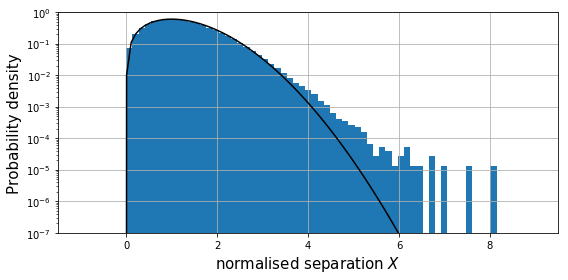

In [27]:
fig,ax=plt.subplots(figsize=(8,4))
#plt.yscale('log')
ax.set_ylim(1e-7, 1.0)
plt.yscale('log', nonposy='clip')

ax.hist(pm_x, 60, normed=1)  
#fitting Rayleigh distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, 100)
from scipy.stats import rayleigh
pdf_g = rayleigh.pdf(lnspc) # now get theoretical values in our interval  
ax.plot(lnspc, pdf_g, label="Rayleigh", c='k') 
ax.set_xlabel('normalised separation $X$', fontsize=15)
ax.set_ylabel('Probability density', fontsize=15)

fig.tight_layout()
ax.grid(True)
fig.show()
print(np.mean(pm_x), np.median(pm_x), np.var(pm_x))

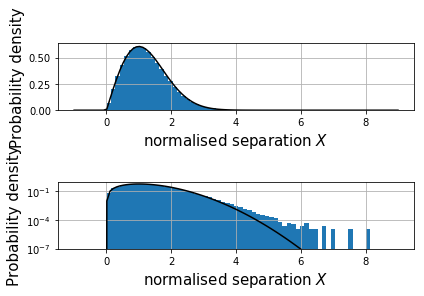

In [33]:
plt.subplot(211)
plt.hist(pm_x, 60, normed=1)
#fitting Rayleigh distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, 100)
from scipy.stats import rayleigh
pdf_g = rayleigh.pdf(lnspc) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Rayleigh", c='k') 
plt.xlabel('normalised separation $X$', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.grid(True)

plt.subplot(212)
plt.ylim(1e-7, 1.0)
plt.yscale('log', nonposy='clip')
plt.hist(pm_x, 60, normed=1)
#fitting Rayleigh distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, 100)
from scipy.stats import rayleigh
pdf_g = rayleigh.pdf(lnspc) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Rayleigh", c='k') 
plt.xlabel('normalised separation $X$', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.grid(True)

plt.tight_layout()
plt.show()

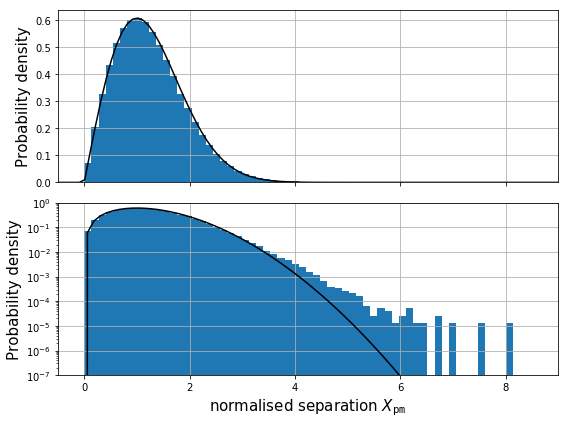

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,6))

ax1.hist(pm_x, 60, normed=1)
#fitting Rayleigh distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, 100)
from scipy.stats import rayleigh
pdf_g = rayleigh.pdf(lnspc) # now get theoretical values in our interval  
ax1.plot(lnspc, pdf_g, label="Rayleigh", c='k') 
#ax1.set_xlabel('normalised separation $X$', fontsize=15)
ax1.set_ylabel('Probability density', fontsize=15)
ax1.grid(True)

ax2.set_ylim(1e-7, 1.0)
plt.yscale('log', nonposy='clip')
ax2.hist(pm_x, 60, normed=1)
#fitting Rayleigh distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, 100)
from scipy.stats import rayleigh
pdf_g = rayleigh.pdf(lnspc) # now get theoretical values in our interval  
ax2.plot(lnspc, pdf_g, label="Rayleigh", c='k') 
ax2.set_xlabel('normalised separation $X_{\\tt pm}$', fontsize=15)
ax2.set_xlim((-0.5,9))
ax2.set_ylabel('Probability density', fontsize=15)
ax2.grid(True)

fig.tight_layout()
fig.show()

fig.savefig('normalised_sep_x.eps')

In [39]:
np.where(pm_x<3.5)[0].size*1.0/pm_x.size

0.9957225128351551

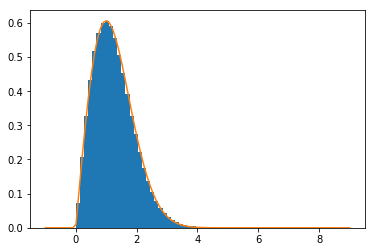

(1.2532724052231732, 1.1678107032308174, 0.45338365529081681)


In [15]:
plt.hist(pm_x_gc_remove, 60, normed=1)  #1.07 是 gaia-crf源pm的低估程度

#fitting Rayleigh distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, 100)
from scipy.stats import rayleigh
pdf_g = rayleigh.pdf(lnspc) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Rayleigh") 
plt.show()

print(np.mean(pm_x_gc_remove), np.median(pm_x_gc_remove), np.var(pm_x_gc_remove))

In [17]:
print(np.sqrt(np.pi/2.0), np.sqrt(2.0*np.log(2)), 2.0-np.pi/2.0)

(1.2533141373155001, 1.1774100225154747, 0.42920367320510344)


In [40]:
np.sqrt(45)-np.sqrt(42)

0.22746323409150904

Global Analysis  全局处理

画每个periods_used中有多少matched_obs

###FIG 2 in Lindergen2018. relation between the visibility period used and matched obs

同时再作每个periods_used中的sigma_5d分布

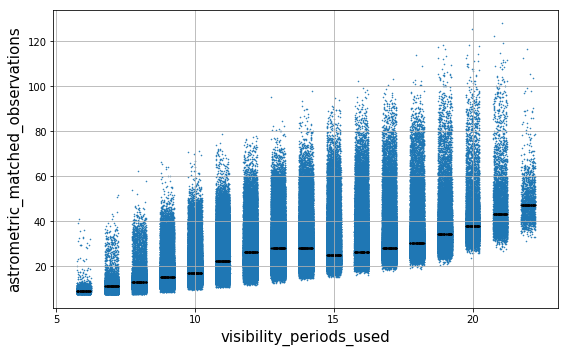

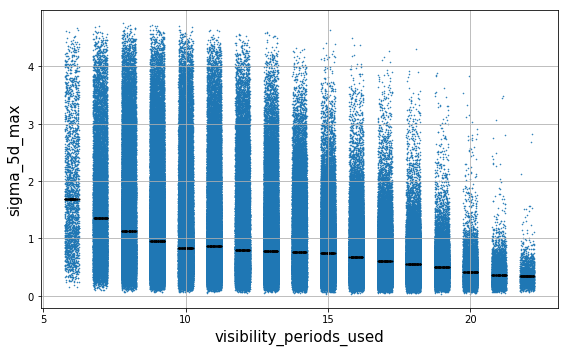

In [54]:
fig,ax=plt.subplots(figsize=(8,5))
matched_obs_median=np.zeros_like(np.unique(periods_used))

ax.scatter(periods_used-0.25+0.5*np.random.random_sample(np.size(periods_used),), \
matched_obs-0.5+1.0*np.random.random_sample(np.size(periods_used),), s=0.3,rasterized=True)

for i in np.unique(periods_used):
    ax.scatter(i*np.ones(50)-0.25+0.5*np.random.random_sample(50,),\
    np.median(matched_obs[np.where(periods_used==i)])*np.ones(50),s=0.9,c='black')

ax.set_xlabel('visibility_periods_used', fontsize=15)
ax.set_ylabel('astrometric_matched_observations', fontsize=15)

my_x_ticks = np.arange(5, 25, 5)
ax.set_xticks(my_x_ticks)

ax.grid(True)
fig.tight_layout()
fig.savefig('period_matchedobs.png',format='png',dpi=300)

####
fig,ax=plt.subplots(figsize=(8,5))
sigma_median=np.zeros_like(np.unique(periods_used))

ax.scatter(periods_used-0.25+0.5*np.random.random_sample(np.size(periods_used),), \
sigma5d_max, s=0.3,rasterized=True)

for i in np.unique(periods_used):
    ax.scatter(i*np.ones(50)-0.25+0.5*np.random.random_sample(50,),\
    np.median(sigma5d_max[np.where(periods_used==i)])*np.ones(50),s=0.9,c='black')

ax.set_xlabel('visibility_periods_used', fontsize=15)
ax.set_ylabel('sigma_5d_max', fontsize=15)

my_x_ticks = np.arange(5, 25, 5)
ax.set_xticks(my_x_ticks)

ax.grid(True)
fig.tight_layout()

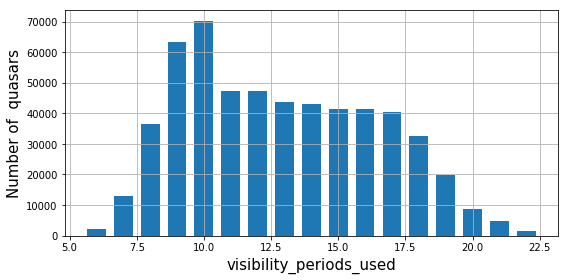

In [12]:
fig,ax=plt.subplots(figsize=(8,4))
bins=np.arange(5.5,23.5,1)
ax.hist(periods_used,bins=bins,histtype='bar', rwidth=0.7, align='mid')
ax.set_xlabel('visibility_periods_used', fontsize=15)
ax.set_ylabel('Number of  quasars', fontsize=15)
#ax.set_title('Distribution of source number',fontsize=20)
fig.tight_layout()
ax.grid(True)
fig.savefig('periods_size.eps')

In [220]:
print(bins)

[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [9]:
aim=sigma5d_max
aim_name='sigma_5d_max'

delta=10000
#10000 sources a bin
sort_pos=np.argsort(aim,axis=0)

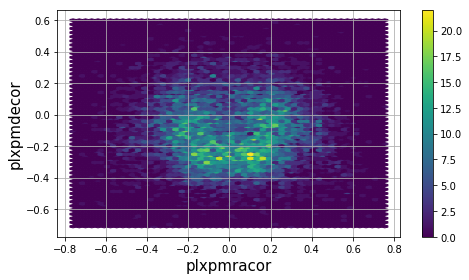

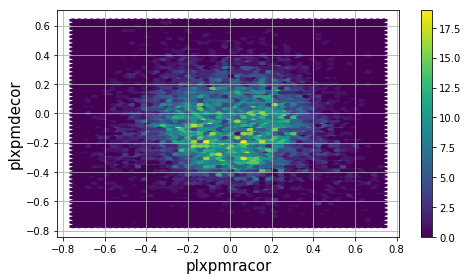

In [288]:
###最高精度的不稳定性
fig, ax = plt.subplots(figsize=(7, 4))
condi=sort_pos[0:10000]
hex_bin=ax.hexbin(plxpmracor[condi],plxpmdecor[condi],gridsize=(50,50))
ax.grid(True)
ax.set_ylabel('plxpmdecor',fontsize=15)
ax.set_xlabel('plxpmracor',fontsize=15)
fig.tight_layout()
fig.colorbar(hex_bin)
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
rank=3
condi=sort_pos[(rank*10000):(rank*10000+10000)]
hex_bin=ax.hexbin(plxpmracor[condi],plxpmdecor[condi],gridsize=(50,50))
ax.grid(True)
ax.set_ylabel('plxpmdecor',fontsize=15)
ax.set_xlabel('plxpmracor',fontsize=15)
fig.tight_layout()
fig.colorbar(hex_bin)
plt.show()

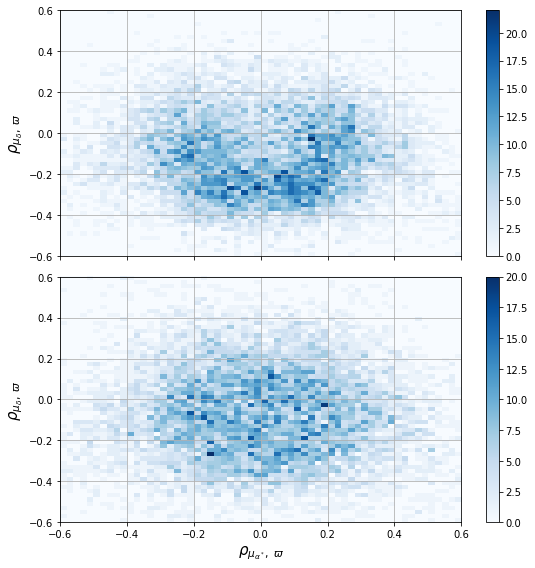

In [91]:
#fig, ax = plt.subplots(figsize=(7, 4))
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,8))

#condi=np.where(g_mag <= 19.5)
#condi=np.where(g_mag > 19.5)
condi=np.where(g_mag < 21)
aim=sigma5d_max[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]
x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'

#aim=sigma5d_max
#x_value=plxpmracor
#x_name='plxpmracor'
#y_value=plxpmdecor
#y_name='plxpmdecor'

sort_pos=np.argsort(aim,axis=0)

rank=0
condi=sort_pos[(rank*10000):(rank*10000+10000)]

hex_bin1=ax1.hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax1.grid(True)
ax1.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=ax1)

rank=10
condi=sort_pos[(rank*10000):(rank*10000+10000)]
hex_bin2=ax2.hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax2.grid(True)
ax2.set_xlabel(x_name,fontsize=15)
ax2.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=ax2)

fig.tight_layout()
plt.savefig('plxpmcor_compare.eps', dpi=400, bbox_inches = "tight")

24589


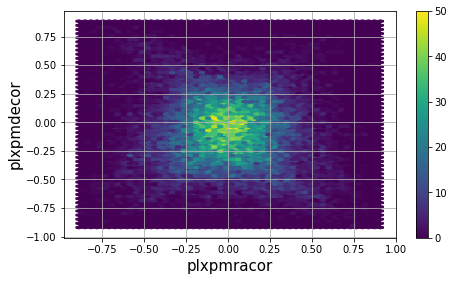

In [315]:
fig, ax = plt.subplots(figsize=(7, 4))
condi=np.where(uwe<=0.95)
#condi=np.where(periods_used<=7)

print(condi[0].size)
hex_bin=ax.hexbin(plxpmracor[condi],plxpmdecor[condi],gridsize=(50,50))
ax.grid(True)
ax.set_ylabel('plxpmdecor',fontsize=15)
ax.set_xlabel('plxpmracor',fontsize=15)
fig.tight_layout()
fig.colorbar(hex_bin)
plt.show()

In [14]:
periods_used.size

556869

556869
232318
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0049759201)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.051956847)
-0.0276444890586
169745
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.007113636)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.045070406)
-0.0326046341183
67296
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0077743605)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.13022098)
-0.0331995291473


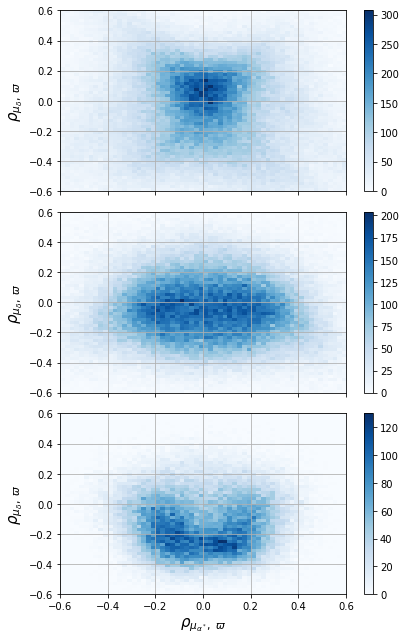

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(6,9))

##研究视星等对结果的影响
condi=np.where(g_mag <= 21)
#fig_name='plxpmcor_compare_2_mag_less_195.eps''
#condi=np.where(g_mag > 19.5)
#fig_name=''plxpmcor_compare_2_mag_more_195.eps''
#condi=np.where(bp_rp > 0.7)
#condi=np.where(bp_rp <= 0.7)
print(condi[0].size)

aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]

x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
plx_value=plx[condi]

#aim=periods_used
#x_value=plxpmracor
#x_name='plxpmracor'
#y_value=plxpmdecor
#y_name='plxpmdecor'
fig_name='plxpmcor_compare_2.eps'


condi=np.where(aim<=11)
#condi=np.where(aim<=9)
#condi=np.where((aim<=11) & (aim>=8))
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=ax1.hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax1.grid(True)
ax1.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=ax1)

condi=np.where((aim<=16) & (aim>=13))
#condi=np.where((aim<=16) & (aim>=14))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=ax2.hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax2.grid(True)
ax2.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=ax2)

condi=np.where(aim>=18)
#condi=np.where((aim<=17) & (aim>=16))
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=ax3.hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax3.grid(True)
ax3.set_xlabel(x_name,fontsize=15)
ax3.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=ax3)

fig.tight_layout()
plt.savefig(fig_name, dpi=400, bbox_inches = "tight")

281328
57760
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.00075110025)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.053708311)
-0.0309819731881
70485
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0022270519)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.033758622)
-0.0322947767053
29778
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.010809232)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.12458823)
-0.0336595335184
275541
57113
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.00048919959)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.08484593)
-0.0314016973911
55451
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0062147472)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.036804102)
-0.0318894456526
37518
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0053655845)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.13469167)
-0.0328344241266


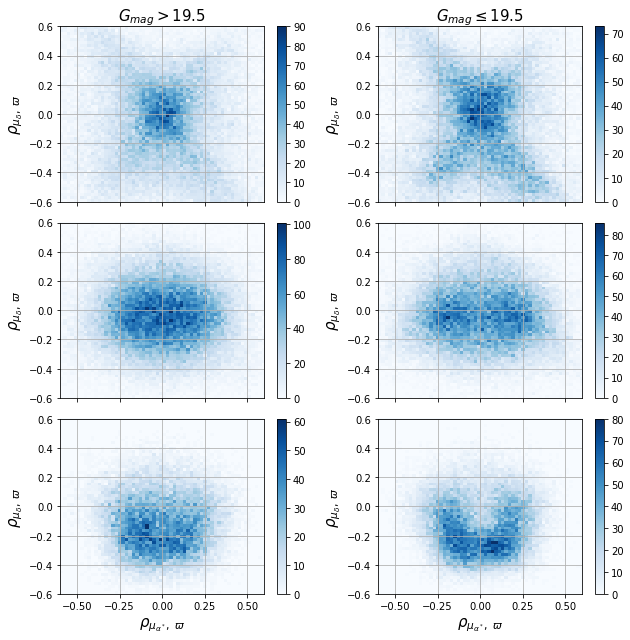

In [105]:
fig, axes= plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(9,9))

##研究视星等对结果的影响
#condi=np.where(g_mag <= 21)
#fig_name='plxpmcor_compare_2_mag_less_195.eps''
condi=np.where(g_mag > 19.5)
#fig_name=''plxpmcor_compare_2_mag_more_195.eps''
#condi=np.where(bp_rp > 0.7)
#condi=np.where(bp_rp <= 0.7)
print(condi[0].size)
axes[0, 0].set_title('$G_{mag} > 19.5$',fontsize=15)

aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]

x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
plx_value=plx[condi]

#aim=periods_used
#x_value=plxpmracor
#x_name='plxpmracor'
#y_value=plxpmdecor
#y_name='plxpmdecor'
fig_name='mag_plxpmcor_compare.eps'

condi=np.where(aim<=9)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[0, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 0].grid(True)
axes[0, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[0, 0])

condi=np.where((aim<=16) & (aim>=14))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[1, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 0].grid(True)
axes[1, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[1, 0])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[2, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[2, 0].grid(True)
axes[2, 0].set_xlabel(x_name,fontsize=15)
axes[2, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[2, 0])

####################################
condi=np.where(g_mag <= 19.5)
print(condi[0].size)
axes[0, 1].set_title('$G_{mag} \\leq 19.5$',fontsize=15)

aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]
plx_value=plx[condi]

condi=np.where(aim<=9)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[0, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 1].grid(True)
axes[0, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[0, 1])

condi=np.where((aim<=16) & (aim>=14))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[1, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 1].grid(True)
axes[1, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[1, 1])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[2, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[2, 1].grid(True)
axes[2, 1].set_xlabel(x_name,fontsize=15)
axes[2, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[2, 1])

fig.tight_layout()
plt.savefig(fig_name, dpi=400, bbox_inches = "tight")

281328
113841
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0037556649)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.042009812)
-0.0275756829545
93493
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.003636918)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.03974491)
-0.0349782962296
29778
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.010809232)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.12458823)
-0.0336595335184
275541
118477
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0061484254)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.06151465)
-0.0277106027828
76252
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.01137646)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.051600046)
-0.0296942738423
37518
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0053655845)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.13469167)
-0.0328344241266


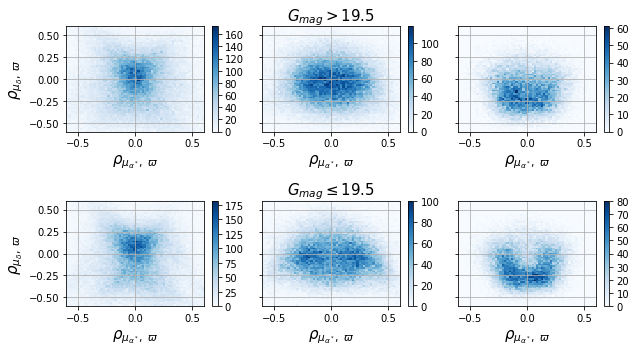

In [46]:
fig, axes= plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(9,5))

##研究视星等对结果的影响
#condi=np.where(g_mag <= 21)
#fig_name='plxpmcor_compare_2_mag_less_195.eps''
condi=np.where(g_mag > 19.5)
#fig_name=''plxpmcor_compare_2_mag_more_195.eps''
#condi=np.where(bp_rp > 0.7)
#condi=np.where(bp_rp <= 0.7)
print(condi[0].size)
axes[0, 1].set_title('$G_{mag} > 19.5$',fontsize=15)
#axes[0, 1].set_title('$G_{BP} - G_{RP} > 0.7$',fontsize=15)


aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]

x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
plx_value=plx[condi]

#aim=periods_used
#x_value=plxpmracor
#x_name='plxpmracor'
#y_value=plxpmdecor
#y_name='plxpmdecor'
fig_name='mag_plxpmcor_compare.eps'
#fig_name='color_plxpmcor_compare.eps'

condi=np.where(aim<=11)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[0, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 0].grid(True)
axes[0, 0].set_xlabel(x_name,fontsize=15)
axes[0, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[0, 0])

condi=np.where((aim<=16) & (aim>=13))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[0, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 1].grid(True)
axes[0, 1].set_xlabel(x_name,fontsize=15)
#axes[0, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[0, 1])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[0, 2].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 2].grid(True)
axes[0, 2].set_xlabel(x_name,fontsize=15)
#axes[0, 2].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[0, 2])

####################################
condi=np.where(g_mag <= 19.5)
#condi=np.where(bp_rp <= 0.7)

print(condi[0].size)
axes[1, 1].set_title('$G_{mag} \\leq 19.5$',fontsize=15)
#axes[1, 1].set_title('$G_{BP} - G_{RP} \\leq 0.7$',fontsize=15)


aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]
plx_value=plx[condi]

condi=np.where(aim<=11)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[1, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 0].grid(True)
axes[1, 0].set_ylabel(y_name,fontsize=15)
axes[1, 0].set_xlabel(x_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[1, 0])

condi=np.where((aim<=16) & (aim>=13))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[1, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 1].grid(True)
axes[1, 1].set_xlabel(x_name,fontsize=15)
#axes[1, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[1, 1])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[1, 2].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 2].grid(True)
axes[1, 2].set_xlabel(x_name,fontsize=15)
#axes[1, 2].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[1, 2])

fig.tight_layout()
plt.savefig(fig_name, dpi=400, bbox_inches = "tight")

/home/scrachel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/home/scrachel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in less_equal


284280
125570
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0046424512)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.033862457)
-0.0317676743446
87690
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.005067952)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.030123396)
-0.0366467285214
26789
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0069596185)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.10757377)
-0.0435756521349
270435
105469
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0060416586)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.073049515)
-0.0225068721114
81625
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0095177051)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.061146151)
-0.0282437601922
40355
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0077061374)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.14549467)
-0.0265908487074


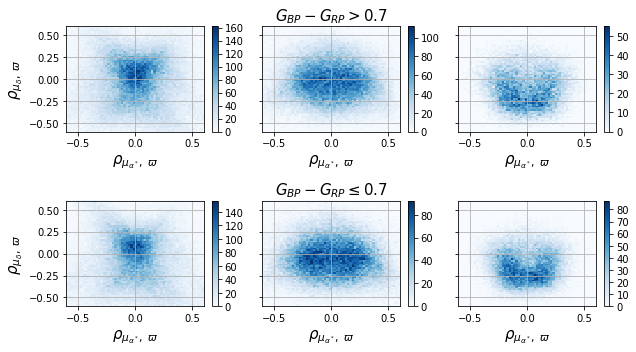

In [47]:
fig, axes= plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(9,5))

##研究视星等对结果的影响
#condi=np.where(g_mag <= 21)
#fig_name='plxpmcor_compare_2_mag_less_195.eps''
#condi=np.where(g_mag > 19.5)
#fig_name=''plxpmcor_compare_2_mag_more_195.eps''
condi=np.where(bp_rp > 0.7)
#condi=np.where(bp_rp <= 0.7)
print(condi[0].size)
#axes[0, 1].set_title('$G_{mag} > 19.5$',fontsize=15)
axes[0, 1].set_title('$G_{BP} - G_{RP} > 0.7$',fontsize=15)


aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]

x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
plx_value=plx[condi]

#aim=periods_used
#x_value=plxpmracor
#x_name='plxpmracor'
#y_value=plxpmdecor
#y_name='plxpmdecor'
#fig_name='mag_plxpmcor_compare.eps'
fig_name='color_plxpmcor_compare.eps'

condi=np.where(aim<=11)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[0, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 0].grid(True)
axes[0, 0].set_xlabel(x_name,fontsize=15)
axes[0, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[0, 0])

condi=np.where((aim<=16) & (aim>=13))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[0, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 1].grid(True)
axes[0, 1].set_xlabel(x_name,fontsize=15)
#axes[0, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[0, 1])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[0, 2].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 2].grid(True)
axes[0, 2].set_xlabel(x_name,fontsize=15)
#axes[0, 2].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[0, 2])

####################################
#condi=np.where(g_mag <= 19.5)
condi=np.where(bp_rp <= 0.7)

print(condi[0].size)
#axes[1, 1].set_title('$G_{mag} \\leq 19.5$',fontsize=15)
axes[1, 1].set_title('$G_{BP} - G_{RP} \\leq 0.7$',fontsize=15)


aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]
plx_value=plx[condi]

condi=np.where(aim<=11)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[1, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 0].grid(True)
axes[1, 0].set_ylabel(y_name,fontsize=15)
axes[1, 0].set_xlabel(x_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[1, 0])

condi=np.where((aim<=16) & (aim>=13))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[1, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 1].grid(True)
axes[1, 1].set_xlabel(x_name,fontsize=15)
#axes[1, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[1, 1])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[1, 2].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 2].grid(True)
axes[1, 2].set_xlabel(x_name,fontsize=15)
#axes[1, 2].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[1, 2])

fig.tight_layout()
plt.savefig(fig_name, dpi=400, bbox_inches = "tight")

/home/scrachel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/home/scrachel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less_equal


284280
61820
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0013912151)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.053571284)
-0.0376431714803
64389
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0038022923)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.020541981)
-0.0335292389074
26789
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0069596185)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.10757377)
-0.0435756521349
270435
52319
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0022752252)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.087622635)
-0.0232947530744
61272
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', 0.0043444228)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.050386488)
-0.0304374720878
40355
('$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$', -0.0077061374)
('$\\rho_{\\mu_{\\delta},\\ \\varpi}$', -0.14549467)
-0.0265908487074


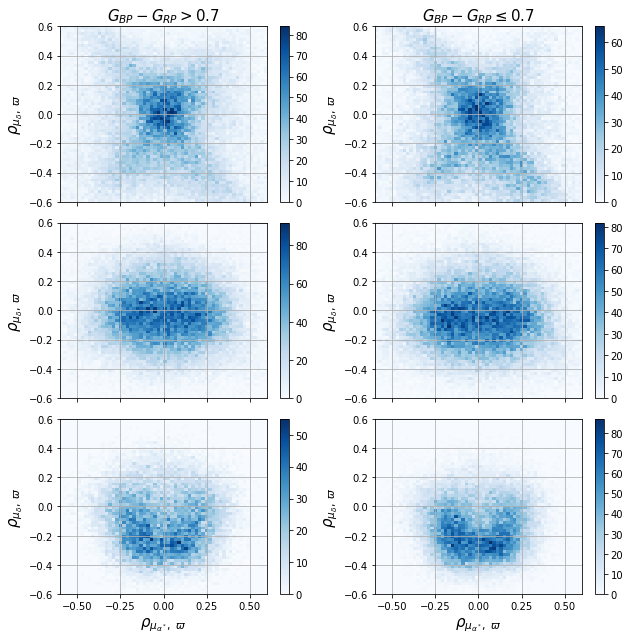

In [115]:
fig, axes= plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(9,9))

##研究视星等对结果的影响
#condi=np.where(g_mag <= 21)
#fig_name='plxpmcor_compare_2_mag_less_195.eps''
condi=np.where(bp_rp > 0.7)
#fig_name=''plxpmcor_compare_2_mag_more_195.eps''
#condi=np.where(bp_rp > 0.7)
#condi=np.where(bp_rp <= 0.7)
print(condi[0].size)
axes[0, 0].set_title('$G_{BP} - G_{RP} > 0.7$',fontsize=15)

aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]

x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
plx_value=plx[condi]

#aim=periods_used
#x_value=plxpmracor
#x_name='plxpmracor'
#y_value=plxpmdecor
#y_name='plxpmdecor'
fig_name='color_plxpmcor_compare.eps'

condi=np.where(aim<=9)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[0, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 0].grid(True)
axes[0, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[0, 0])

condi=np.where((aim<=16) & (aim>=14))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[1, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 0].grid(True)
axes[1, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[1, 0])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[2, 0].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[2, 0].grid(True)
axes[2, 0].set_xlabel(x_name,fontsize=15)
axes[2, 0].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[2, 0])

####################################
condi=np.where(bp_rp <= 0.7)
print(condi[0].size)
axes[0, 1].set_title('$G_{BP} - G_{RP} \\leq 0.7$',fontsize=15)

aim=periods_used[condi]
x_value=plxpmracor[condi]
y_value=plxpmdecor[condi]
plx_value=plx[condi]

condi=np.where(aim<=9)
#condi=np.where(aim==13)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin1=axes[0, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[0, 1].grid(True)
axes[0, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=axes[0, 1])

condi=np.where((aim<=16) & (aim>=14))
#condi=np.where(aim==14)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin2=axes[1, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[1, 1].grid(True)
axes[1, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=axes[1, 1])

condi=np.where(aim>=18)
#condi=np.where(aim==15)
print(condi[0].size)
print(x_name, np.mean(x_value[condi]))
print(y_name, np.mean(y_value[condi]))
print(np.mean(plx_value[condi]))
hex_bin3=axes[2, 1].hist2d(x_value[condi],y_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
axes[2, 1].grid(True)
axes[2, 1].set_xlabel(x_name,fontsize=15)
axes[2, 1].set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin3[3],ax=axes[2, 1])

fig.tight_layout()
plt.savefig(fig_name, dpi=400, bbox_inches = "tight")

In [114]:
condi=np.where(bp_rp < 0.7)
print(condi[0].size)

270435


/home/scrachel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


556869


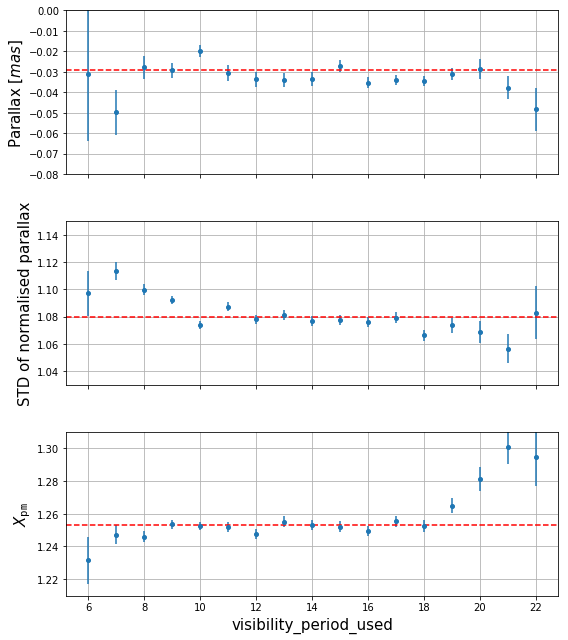

In [8]:
##研究视星等对结果的影响
#condi=np.where(g_mag <= 18.0)
#condi=np.where((g_mag > 18.0) & (g_mag <= 19.0))
#condi=np.where((g_mag > 19.0) & (g_mag <= 19.5))
#condi=np.where((g_mag > 19.5) & (g_mag <= 20.0))
#condi=np.where(g_mag > 20.0)

#condi=np.where(g_mag <= 19.5)
#condi=np.where(g_mag < 19.5)

#full sample
condi=np.where(g_mag < 21)
print(condi[0].size)

#aim=periods_used
aim=periods_used[condi]
aim_name='visibility_period_used'

#aim=matched_obs
#aim_name='matched_observation'

y_value=plx[condi]
e_y_value=e_plx[condi]
#加入pm_x作为分析量
z_value=pm_x[condi]

aim_min=np.min(aim)
aim_max=np.max(aim)
x=np.arange(aim_min, aim_max+1)
count=np.zeros_like(x)
lower_error=np.zeros_like(x,dtype=float)
upper_error=np.zeros_like(x,dtype=float)
median_y=np.zeros_like(x,dtype=float)
mean_y=np.zeros_like(x,dtype=float)
mean_z=np.zeros_like(x,dtype=float)
std_z=np.zeros_like(x,dtype=float)
std_dev=np.zeros_like(x,dtype=float)
std_std_dev=np.zeros_like(x,dtype=float)
#std_x=np.zeros_like(x,dtype=float)
std_mean=np.zeros_like(x,dtype=float)
for coun_i in np.arange(aim_min, aim_max+1):
    select_func=np.where(aim==coun_i)
    count[coun_i-aim_min]=select_func[0].size
    if select_func[0].size > 30:
        median_y[coun_i-aim_min]=np.median(y_value[select_func])
        mean_y[coun_i-aim_min]=np.mean(y_value[select_func])
        lower_error[coun_i-aim_min]=np.std(y_value[select_func])/np.sqrt(select_func[0].size-1)
        upper_error[coun_i-aim_min]=np.std(y_value[select_func])/np.sqrt(select_func[0].size-1)
        ####
        std_dev[coun_i-aim_min]=np.std((y_value[select_func]-mean_y[coun_i-aim_min]) \
                    /e_y_value[select_func])
        #std_x[coun_i-aim_min]=np.std(y_value[select_func])
        std_std_dev[coun_i-aim_min]=std_dev[coun_i-aim_min]/np.sqrt(2.0*select_func[0].size-2.0)
        ###
        mean_z[coun_i-aim_min]=np.mean(z_value[select_func])
        std_z[coun_i-aim_min]=np.std(z_value[select_func])/np.sqrt(select_func[0].size-1.0)
        
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8,9))
indx=np.where(mean_y != 0)
ax1.errorbar(x[indx], mean_y[indx], yerr=[lower_error[indx], upper_error[indx]],
            marker='o', markersize=4, linestyle='none')
#ax.set_title('Parallax distribution',fontsize=20)
#ax1.set_xlabel('visibility_period_used',fontsize=15)
ax1.set_ylabel('Parallax [$mas$]',fontsize=15)
ax1.set_ylim((-0.08,0.0))

ax2.errorbar(x[indx], std_dev[indx], yerr=std_std_dev[indx],
            marker='o', markersize=4, linestyle='none')
#ax.set_title('Parallax formal error distribution',fontsize=18)
#ax.set_xlabel('SIGMA_5D_MAX',fontsize=15)
ax2.set_ylabel('STD of normalised parallax',fontsize=15)
ax2.set_ylim((1.03,1.15))

ax3.errorbar(x[indx], mean_z[indx], yerr=std_z[indx],
             marker='o', markersize=4, linestyle='none')
ax3.set_xlabel(aim_name,fontsize=15)
ax3.set_ylabel('$X_{\\tt pm}$',fontsize=15)
ax3.set_ylim((1.21,1.31))

ax_x_min, ax_x_max = ax1.get_xlim()
ax1.hlines(-0.029, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax1.set_xlim(ax_x_min, ax_x_max)
ax_x_min, ax_x_max = ax2.get_xlim()
ax2.hlines(1.08, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax2.set_xlim(ax_x_min, ax_x_max)
ax_x_min, ax_x_max = ax3.get_xlim()
ax3.hlines(1.253, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax3.set_xlim(ax_x_min, ax_x_max)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
fig.tight_layout()
fig.savefig(aim_name+'.eps')

In [30]:
np.max(g_mag)

20.999922

In [32]:
np.sum(np.isnan(bp_rp))

2154

27275
123236
125028
125028
148909


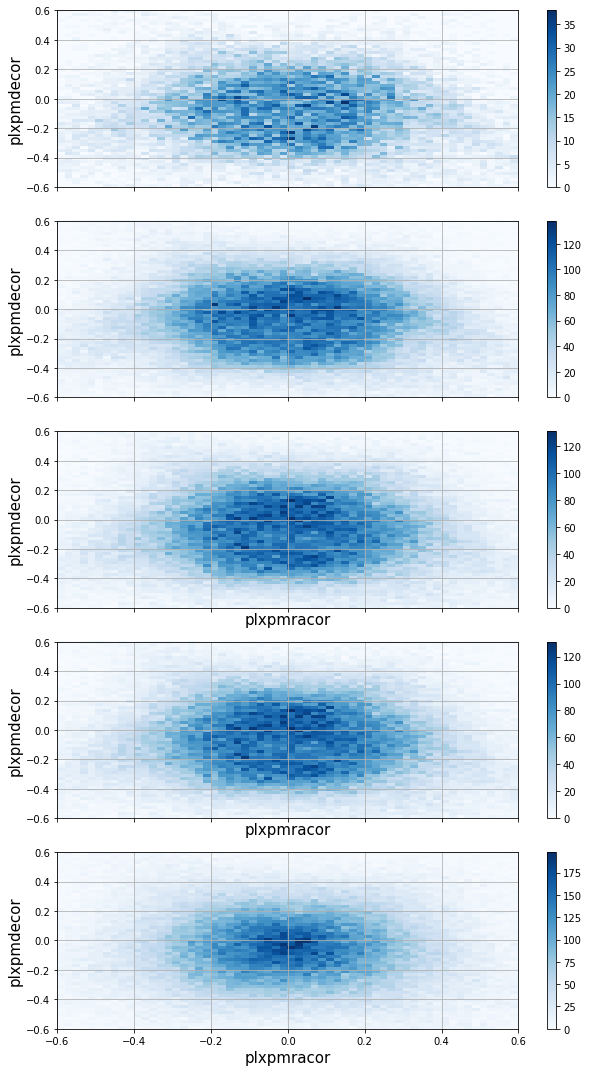

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharex=True, figsize=(9,15))

#condi=np.where(periods_used<=9)
condi=np.where(g_mag < 18.0)
print(condi[0].size)
hex_bin1=ax1.hist2d(plxpmracor[condi],plxpmdecor[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax1.grid(True)
ax1.set_ylabel('plxpmdecor',fontsize=15)
fig.colorbar(hex_bin1[3], ax=ax1)

#condi=np.where((periods_used<=16) & (periods_used>=14))
condi=np.where((g_mag > 18.0) & (g_mag < 19.0))
print(condi[0].size)
hex_bin2=ax2.hist2d(plxpmracor[condi],plxpmdecor[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax2.grid(True)
ax2.set_ylabel('plxpmdecor',fontsize=15)
fig.colorbar(hex_bin2[3],ax=ax2)

#condi=np.where(periods_used>=18)
condi=np.where((g_mag > 19.0) & (g_mag < 19.5))
print(condi[0].size)
hex_bin3=ax3.hist2d(plxpmracor[condi],plxpmdecor[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax3.grid(True)
ax3.set_xlabel('plxpmracor',fontsize=15)
ax3.set_ylabel('plxpmdecor',fontsize=15)
fig.colorbar(hex_bin3[3],ax=ax3)

condi=np.where((g_mag > 19.0) & (g_mag < 19.5))
print(condi[0].size)
hex_bin4=ax4.hist2d(plxpmracor[condi],plxpmdecor[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax4.grid(True)
ax4.set_xlabel('plxpmracor',fontsize=15)
ax4.set_ylabel('plxpmdecor',fontsize=15)
fig.colorbar(hex_bin4[3],ax=ax4)

condi=np.where(g_mag > 20.0)
print(condi[0].size)
hex_bin5=ax5.hist2d(plxpmracor[condi],plxpmdecor[condi],bins=60,cmap=plt.cm.Blues, range=np.array([-0.6,0.6,-0.6,0.6]).reshape(2,2))
ax5.grid(True)
ax5.set_xlabel('plxpmracor',fontsize=15)
ax5.set_ylabel('plxpmdecor',fontsize=15)
fig.colorbar(hex_bin5[3],ax=ax5)

fig.tight_layout()
#plt.savefig('plxpmcor_compare_2.eps', dpi=400, bbox_inches = "tight")

556869


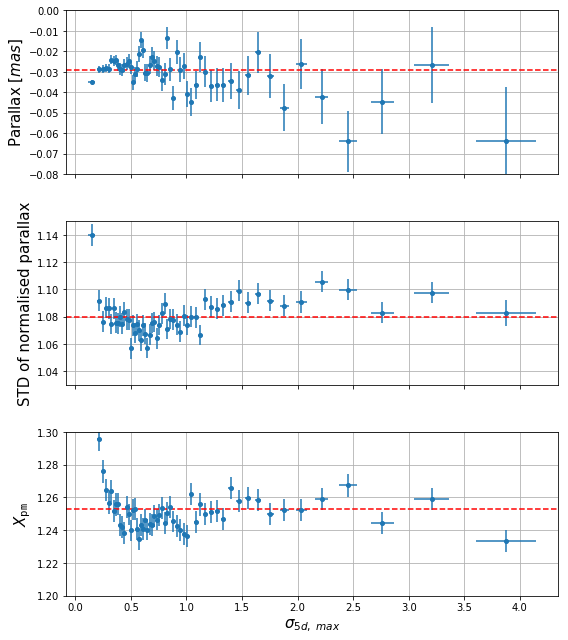

In [11]:
aim=sigma5d_max
aim_name='astrometric_sigma5d_max'

#aim=sigma_pm_max
#aim=sigma_pos_max

#aim=g_mag
#aim_name='g_mag'

#aim=np.sqrt((0.06+plxpmdecor)**2.0+plxpmracor**2.0)
#aim_name='PM X mean'

#aim=uwe
#aim_name='unit_weight_error'

#y_value=plx
#e_y_value=e_plx

##研究视星等对结果的影响
#condi=np.where(g_mag <= 19.5)
#condi=np.where(g_mag > 19.5)

#full sample
condi=np.where(g_mag < 21)
print(condi[0].size)

aim=aim[condi]
y_value=plx[condi]
e_y_value=e_plx[condi]
z_value=pm_x[condi]

delta=10000
#10000 sources a bin
sort_pos=np.argsort(aim,axis=0)

x=np.zeros(sort_pos.size/delta+1)
std_x=np.zeros_like(x)
#median_y=np.zeros_like(x)
mean_y=np.zeros_like(x)
std_mean_y=np.zeros_like(x)
mean_z=np.zeros_like(x)
std_z=np.zeros_like(x)
std_dev=np.zeros_like(x)
std_std_dev=np.zeros_like(x)

for coun_i in np.arange(sort_pos.size/delta):
    mean_y[coun_i]=np.mean(y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_mean_y[coun_i]=np.std(y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])/np.sqrt(delta-1.0)
    #Standard deviation of formal error
    std_dev[coun_i]=np.std((y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]]-mean_y[coun_i]) \
                    /e_y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_std_dev[coun_i]=std_dev[coun_i]/np.sqrt(2.0*delta-2.0)

    x[coun_i]=np.mean(aim[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_x[coun_i]=np.std(aim[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    
    mean_z[coun_i]=np.mean(z_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_z[coun_i]=np.std(z_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])/np.sqrt(delta-1.0)
    
sort_left=sort_pos[(coun_i+1)*delta:]
mean_y[coun_i+1]=np.mean(y_value[sort_left])
std_mean_y[coun_i+1]=np.std(y_value[sort_left])/np.sqrt(sort_left.size-1.0)
std_dev[coun_i+1]=np.std((y_value[sort_left]-mean_y[coun_i+1])/e_y_value[sort_left])
std_std_dev[coun_i+1]=std_dev[coun_i+1]/np.sqrt(2.0*sort_left.size-2.0)
x[coun_i+1]=np.mean(aim[sort_left])
std_x[coun_i+1]=np.std(aim[sort_left])
mean_z[coun_i+1]=np.mean(z_value[sort_left])
std_z[coun_i+1]=np.std(z_value[sort_left])/np.sqrt(delta-1.0)
#mean[coun_i+1]=np.mean(plx[sort_pos[(coun_i+1)*delta:]])
#std_mean[coun_i+1]=np.std(plx[sort_pos[(coun_i+1)*delta:]])/np.sqrt(sort_pos.size%delta-1.0)

        
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8,9))
ax1.errorbar(x, mean_y, xerr=std_x, yerr=std_mean_y, marker='o', markersize=4, linestyle='none')
ax1.set_ylabel('Parallax [$mas$]',fontsize=15)
ax1.set_ylim((-0.08,0.0))

ax2.errorbar(x, std_dev, xerr=std_x, yerr=std_std_dev, marker='o', markersize=4, linestyle='none')
#ax.set_title('Parallax formal error distribution',fontsize=18)
#ax.set_xlabel('SIGMA_5D_MAX',fontsize=15)
#ax2.set_xlabel(aim_name,fontsize=15)
ax2.set_ylabel('STD of normalised parallax',fontsize=15)
ax2.set_ylim((1.03,1.15))
#作uwe的图时候加xlim
#ax1.set_xlim((0.8, 1.6))

ax3.errorbar(x, mean_z, xerr=std_x, yerr=std_z, marker='o', markersize=4, linestyle='none')

ax3.set_xlabel('$\sigma_{5d,\ max}$',fontsize=15)
ax3.set_ylim((1.2,1.3))

#ax3.set_xlabel('unit weight error $u$',fontsize=15)
#ax3.set_ylim((1.2,1.35))

ax3.set_ylabel('$X_{\\tt pm}$',fontsize=15)

ax_x_min, ax_x_max = ax1.get_xlim()
ax1.hlines(-0.029, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax1.set_xlim(ax_x_min, ax_x_max)
ax_x_min, ax_x_max = ax2.get_xlim()
ax2.hlines(1.08, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax2.set_xlim(ax_x_min, ax_x_max)
ax_x_min, ax_x_max = ax3.get_xlim()
ax3.hlines(1.253, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax3.set_xlim(ax_x_min, ax_x_max)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
fig.tight_layout()
fig.savefig(aim_name+'.eps')

In [64]:
print(x)
print(mean_z)

[ 0.14834134  0.20977503  0.24611108  0.27537709  0.30076608  0.324119
  0.34539139  0.36574575  0.38560346  0.40480176  0.4237211   0.44233853
  0.46079019  0.479092    0.49723995  0.51552629  0.53396136  0.55223453
  0.57048672  0.58916575  0.60821223  0.62767726  0.64768296  0.66795039
  0.68878084  0.71001464  0.73192614  0.75493312  0.77864134  0.80313343
  0.82865018  0.85554355  0.88309515  0.91208947  0.94267207  0.97462922
  1.00866961  1.04525816  1.08388627  1.12568319  1.17027915  1.21914673
  1.2719512   1.33135796  1.3967042   1.4694742   1.55152822  1.64581978
  1.75420785  1.88061273  2.03344774  2.21746397  2.45443511  2.76282716
  3.20572829  3.87480664]
[ 1.38086423  1.29537832  1.27578682  1.26453013  1.25669554  1.26386675
  1.25164547  1.25563965  1.25568208  1.24315379  1.24206873  1.23822175
  1.25426513  1.24953393  1.23973268  1.25240415  1.25307593  1.24043804
  1.23425305  1.24294409  1.24079096  1.24594908  1.24031841  1.24348537
  1.24322457  1.24870855  1

上图中 std of formal error & pm_X 同趋势可能只有在相似的观测周期(periods_used)中成立。

In [44]:
np.mean(uwe[sort_pos[0:delta]])

1.0781325033203271

以下这个废弃

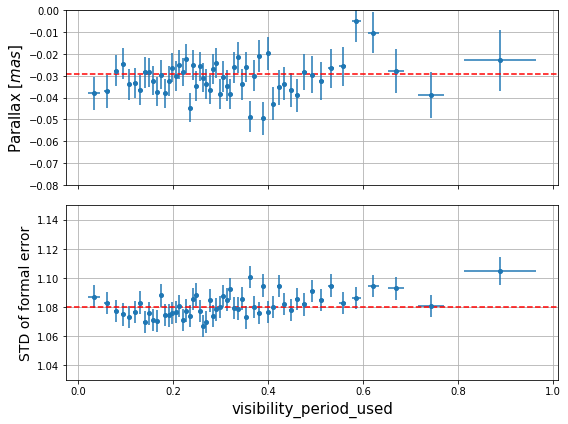

In [92]:
aim=np.sqrt((0.06+plxpmdecor)**2.0+plxpmracor**2.0)
y_value=plx
e_y_value=e_plx

#y_value=pm_x
#e_y_value=pm_x


delta=10000
#10000 sources a bin
sort_pos=np.argsort(aim,axis=0)

x=np.zeros(sort_pos.size/delta+1)
std_x=np.zeros_like(x)
median=np.zeros_like(x)
mean=np.zeros_like(x)
std_dev=np.zeros_like(x)
std_std_dev=np.zeros_like(x)
std_mean=np.zeros_like(x)

for coun_i in np.arange(sort_pos.size/delta):
    mean[coun_i]=np.mean(y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_mean[coun_i]=np.std(y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])/np.sqrt(delta-1.0)
    std_dev[coun_i]=np.std((y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]]-mean[coun_i]) \
                    /e_y_value[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    #Standard deviation of formal error
    x[coun_i]=np.mean(aim[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_x[coun_i]=np.std(aim[sort_pos[coun_i*delta:(coun_i+1)*delta]])
    std_std_dev[coun_i]=std_dev[coun_i]/np.sqrt(2.0*delta-2.0)
    
sort_left=sort_pos[(coun_i+1)*delta:]
mean[coun_i+1]=np.mean(y_value[sort_left])
std_mean[coun_i+1]=np.std(y_value[sort_left])/np.sqrt(sort_left.size-1.0)
std_dev[coun_i+1]=np.std((y_value[sort_left]-mean[coun_i+1])/e_y_value[sort_left])
x[coun_i+1]=np.mean(aim[sort_left])
std_x[coun_i+1]=np.std(aim[sort_left])
std_std_dev[coun_i+1]=std_dev[coun_i+1]/np.sqrt(2.0*sort_left.size-2.0)
#mean[coun_i+1]=np.mean(plx[sort_pos[(coun_i+1)*delta:]])
#std_mean[coun_i+1]=np.std(plx[sort_pos[(coun_i+1)*delta:]])/np.sqrt(sort_pos.size%delta-1.0)

'''###the formal uncertainties of the parallaxes are underestimated by std_x.
fig, ax = plt.subplots(figsize=(8, 4))
#indx=np.where(median != 0)
ax.errorbar(x, std_dev, xerr=std_x, marker='o', markersize=4, linestyle='none')
#ax.errorbar(x+delta/2.0, median, yerr=[lower_error, upper_error],
#            marker='o', markersize=4, linestyle='none')
ax.set_title('Parallax formal error distribution',fontsize=18)
#ax.set_xlabel('SIGMA_5D_MAX',fontsize=15)
ax.set_xlabel(aim_name,fontsize=15)
ax.set_ylabel('Standard deviation of formal error',fontsize=12)
ax.set_ylim((1.0,1.2))
ax.grid(True)
fig.tight_layout()
###Figure of parallax foral
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(x, mean, xerr=std_x, yerr=std_mean, marker='o', markersize=4, linestyle='none')
#ax.errorbar(x+delta/2.0, median, yerr=[lower_error, upper_error],
#            marker='o', markersize=4, linestyle='none')
ax.set_title('Parallax distribution',fontsize=18)
#ax.set_xlabel('SIGMA_5D_MAX',fontsize=15)
ax.set_xlabel(aim_name,fontsize=15)
ax.set_ylabel('Parallax [mas]',fontsize=12)
ax.set_ylim((-0.1,0.0))
ax.grid(True)
fig.tight_layout()'''

        
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
ax1.errorbar(x, mean, xerr=std_x, yerr=std_mean, marker='o', markersize=4, linestyle='none')
ax1.set_ylabel('Parallax [$mas$]',fontsize=15)
ax1.set_ylim((-0.08,0.0))
#ax1.set_ylim((1.35,1.4))  #对于pm_x成图


ax2.errorbar(x, std_dev, xerr=std_x, yerr=std_std_dev, marker='o', markersize=4, linestyle='none')
#ax.set_title('Parallax formal error distribution',fontsize=18)
#ax.set_xlabel('SIGMA_5D_MAX',fontsize=15)
ax2.set_xlabel(aim_name,fontsize=15)
ax2.set_ylabel('STD of formal error',fontsize=14)
ax2.set_ylim((1.03,1.15))
#作uwe的图时候加xlim
#ax1.set_xlim((0.8, 1.6))

ax_x_min, ax_x_max = ax1.get_xlim()
ax1.hlines(-0.029, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax1.set_xlim(ax_x_min, ax_x_max)
ax_x_min, ax_x_max = ax2.get_xlim()
ax2.hlines(1.08, ax_x_min, ax_x_max, colors = "r", linestyles = "dashed")
ax2.set_xlim(ax_x_min, ax_x_max)

ax1.grid(True)
ax2.grid(True)
fig.tight_layout()
#plt.savefig(aim_name+'.eps')

In [94]:
print(np.sqrt(np.pi/2.0), np.sqrt(2.0*np.log2(2.0)))  #Rayleigh distribution mean and median

(1.2533141373155001, 1.4142135623730951)


healpix处理

In [85]:
#nside=16
nside=32
#nside=64
npix = hp.nside2npix(nside)
print(npix)
theta = np.pi /2.0-glat
phi = glon
indices = hp.ang2pix(nside, theta, phi)

12288


计算全天球面有多少平方度，每个healpix的bin占多少平均面积

In [156]:
#nside=32
sphere_area=4*np.pi/(np.pi/180.0)**2
npix = hp.nside2npix(nside)
np.sqrt(sphere_area/npix)

1.8322594196359498

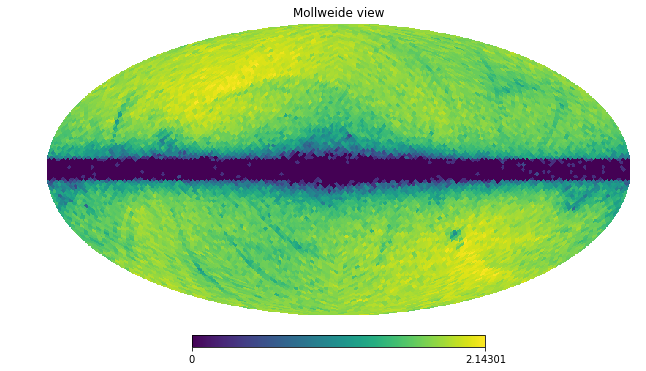

In [70]:
idx, counts = np.unique(indices, return_counts=True)
hpx_count = np.zeros(npix, dtype=int)
hpx_count[idx] = counts
#源分布密度图
hp.mollview(np.log10(hpx_count+1))

以下这个是测试 不同星等分布均匀性，正式计算不要使用

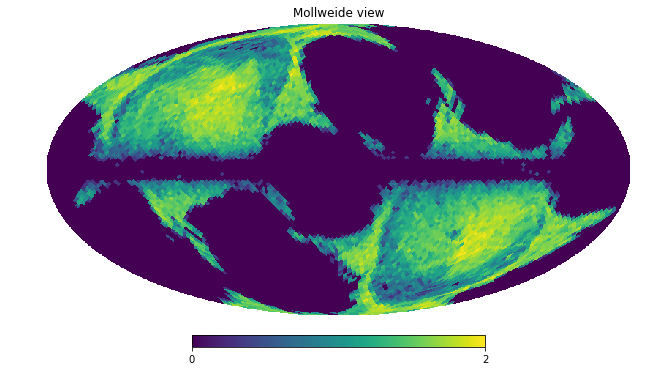

In [79]:
nside=32
#nside=64
npix = hp.nside2npix(nside)
theta = np.pi /2.0-glat
phi = glon

#condi=np.where(periods_used==9)
condi=np.where((periods_used<=16) & (periods_used>=14))
indices = hp.ang2pix(nside, theta[condi], phi[condi])

idx, counts = np.unique(indices, return_counts=True)
hpx_count = np.zeros(npix, dtype=int)
hpx_count[idx] = counts
#源分布密度图
hp.mollview(np.log10(hpx_count+1))

In [86]:
matched_obs_mean=np.zeros(npix)-10.0
matched_obs_std=np.zeros(npix)-10.0
periods_used_mean=np.zeros(npix)-10.0
periods_used_std=np.zeros(npix)-10.0


plx_mean=np.zeros(npix)-10.0
e_plx_mean=np.zeros(npix)-10.0
e_plx_std_mean=np.zeros(npix)-10.0
g_mag_mean=np.zeros(npix)-10.0
bp_rp_mean=np.zeros(npix)-10.0

uwe_mean=np.zeros(npix)-10.0
sigma5d_max_mean=np.zeros(npix)-10.0
plxpmracor_mean=np.zeros(npix)-10.0
plxpmdecor_mean=np.zeros(npix)-10.0
plxpmracor_std=np.zeros(npix)-10.0
plxpmdecor_std=np.zeros(npix)-10.0
######
rapmracor_mean=np.zeros(npix)-10.0
rapmdecor_mean=np.zeros(npix)-10.0
decpmracor_mean=np.zeros(npix)-10.0
decpmdecor_mean=np.zeros(npix)-10.0
raplxcor_mean=np.zeros(npix)-10.0
decplxcor_mean=np.zeros(npix)-10.0

In [88]:
for indice_ in range(0, npix):
    indice_locate = np.where(indices==indice_)
    if indice_locate[0].size > 10:
        plx_mean[indice_]=np.mean(plx[indice_locate])
        e_plx_mean[indice_]=np.mean(e_plx[indice_locate])
        e_plx_std_mean[indice_]=np.std((plx[indice_locate]-plx_mean[indice_])/e_plx[indice_locate])
        
        g_mag_mean[indice_]=np.mean(g_mag[indice_locate])
        bp_rp_mean[indice_]=np.mean(bp_rp[indice_locate])
        
        matched_obs_mean[indice_]=np.mean(matched_obs[indice_locate])
        matched_obs_std[indice_]=np.std(matched_obs[indice_locate])
        periods_used_mean[indice_]=np.mean(periods_used[indice_locate])
        periods_used_std[indice_]=np.std(periods_used[indice_locate]) #检测同区域是否有一致的观测次数
        
        uwe_mean[indice_]=np.mean(uwe[indice_locate])
        sigma5d_max_mean[indice_]=np.mean(sigma5d_max[indice_locate])
        plxpmracor_mean[indice_]=np.mean(plxpmracor[indice_locate])
        plxpmdecor_mean[indice_]=np.mean(plxpmdecor[indice_locate])
        plxpmracor_std[indice_]=np.std(plxpmracor[indice_locate])
        plxpmdecor_std[indice_]=np.std(plxpmdecor[indice_locate])
        ######
        rapmracor_mean[indice_]=np.mean(rapmracor[indice_locate])
        rapmdecor_mean[indice_]=np.mean(rapmdecor[indice_locate])
        decpmracor_mean[indice_]=np.mean(decpmracor[indice_locate])
        decpmdecor_mean[indice_]=np.mean(decpmdecor[indice_locate])
        raplxcor_mean[indice_]=np.mean(raplxcor[indice_locate])
        decplxcor_mean[indice_]=np.mean(decplxcor[indice_locate])

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


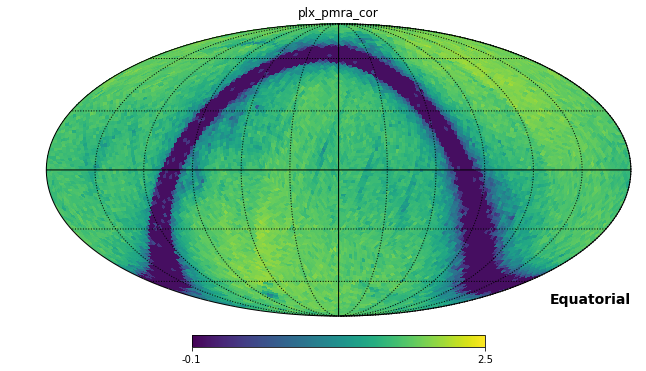

In [147]:
#hp.mollview(plxpmracor_mean,coord=['G','C'], title='plx_pmra_cor', min=-0.9,max=0.9, xsize=2000)
hp.mollview(np.log10(hpx_count+1),coord=['G','C'], title='plx_pmra_cor', min=-0.1,max=2.5, xsize=2000)
hp.graticule()
plt.savefig('plx_pmra_cor_spatial.eps',dpi=300)

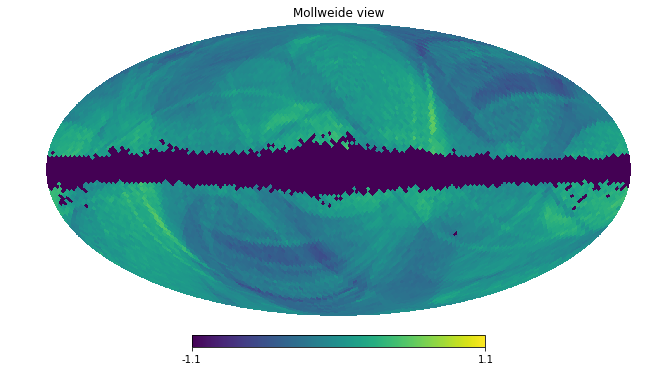

In [319]:
hp.mollview(plxpmdecor_mean,min=-1.1,max=1.1, xsize=2000)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


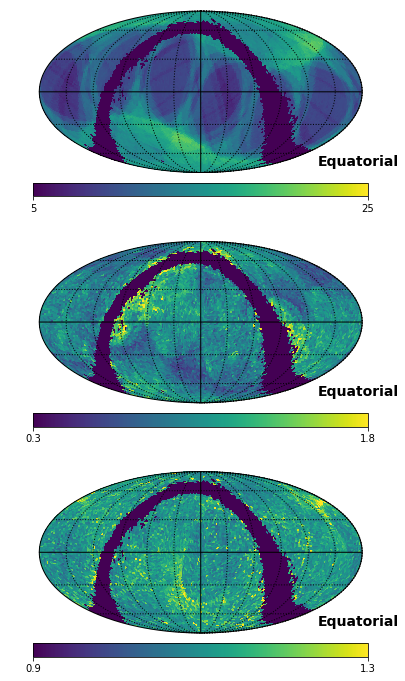

In [111]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12,12))
#fig, (ax1, ax2) = plt.subplots(nrows=2)

plt.axes(ax1)
hp.mollview(periods_used_mean,coord=['G','C'], title='', min=5,max=25, xsize=2000, hold=True)

plt.axes(ax2)
hp.mollview(sigma5d_max_mean,coord=['G','C'], title='',min=0.3,max=1.8, xsize=3000, hold=True)

plt.axes(ax3)
hp.mollview(uwe_mean,coord=['G','C'], title='', min=0.9,max=1.3, xsize=2000, hold=True)

hp.graticule()
fig.tight_layout()
plt.savefig('mean_spatial.eps',dpi=300)

对于源个数大于10个的区域继续分析

0.728496


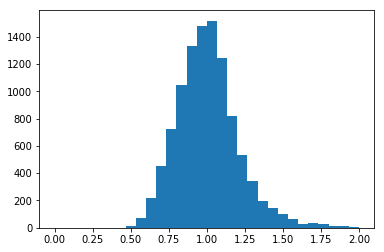

In [76]:
plt.hist(sigma5d_max_mean,30,range=[0.0,2.0])
print(np.std(sigma5d_max))

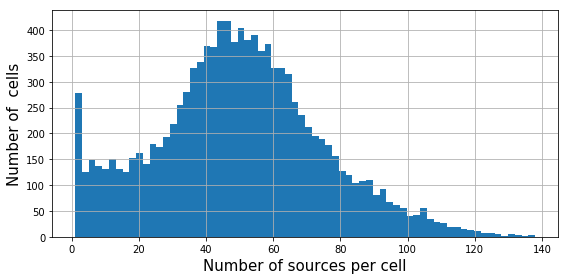

In [196]:
fig,ax=plt.subplots(figsize=(8,4))

count_max=np.max(counts)
count_min=np.min(counts)
bin_count=(count_max-count_min)/2

ax.hist(counts,bins=bin_count)
ax.set_xlabel('Number of sources per cell', fontsize=15)
ax.set_ylabel('Number of  cells', fontsize=15)
#ax.set_title('Distribution of source number', fontsize=20)
ax.grid(True)
fig.tight_layout()
fig.savefig('Distribution_of_cell_source_number.eps')

In [188]:
print(counts.size)
print(counts[np.where(counts>10)].size)
print(np.mean(counts))
print(npix) #总共多少cell

11170
10409
49.8539838854
12288


In [195]:
np.log2(12288/3)

12.0

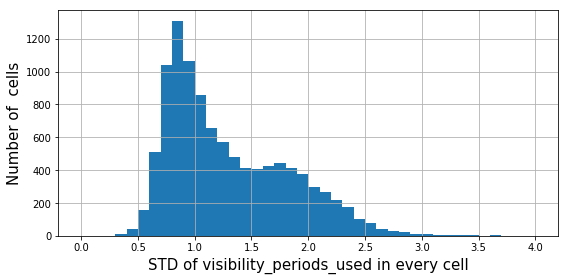

In [93]:
##为了说明分区后 每个区域内源具有的观测一致性 对于全体源的std=3.5        
fig,ax=plt.subplots(figsize=(8,4))
ax.hist(periods_used_std,40,range=(0,4))
ax.set_xlabel('STD of visibility_periods_used in every cell',fontsize=15)
ax.set_ylabel('Number of  cells', fontsize=15)
#ax.set_title('Distribution of source number',fontsize=20)
fig.tight_layout()
ax.grid(True)
fig.savefig('STD_period_spatial.eps')

In [230]:
np.std(periods_used)

3.535761987587632

In [234]:
np.where(periods_used_std<1.5)[0].size
#np.max(periods_used_std)

8977

In [235]:
8977.0/10409

0.8624267460851186

In [18]:
np.std(plxpmdecor)

0.25235453

计算小于平均标准差的bin有多少（排除源个数10个以下的区域）。
为了说明每个bin具有一定的一致性，而不是说相当于整个样本中随机抽取的。
同时可以考察下std比较大的bin在天球的位置。

In [239]:
np.where((plxpmracor_std<np.std(plxpmracor)) & (plxpmracor_std>0))[0].size*1.0/plxpmracor_std[np.where(plxpmracor_std>0)].size

0.9654145451051974

In [240]:
np.where((plxpmracor_std<0.2) & (plxpmracor_std>0))[0].size*1.0/plxpmracor_std[np.where(plxpmracor_std>0)].size

0.8057450283408589

11.7352826902
0.252355


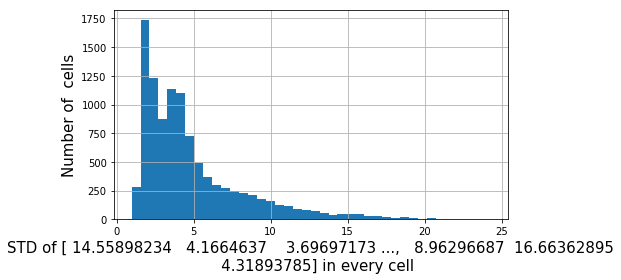

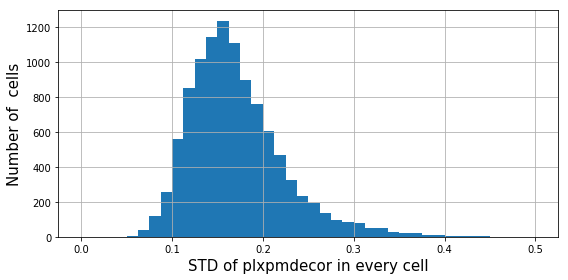

In [248]:
#condi=np.where((plxpmracor_std<np.std(plxpmracor)) & (plxpmracor_std>0))
obj=matched_obs_std
print(np.std())
condi=np.where(plxpmracor_std>0)
fig,ax=plt.subplots(figsize=(8,4))
#ax.hist(plxpmracor_std[condi],40,range=(0,0.5))
ax.hist(obj[condi],40)
ax.set_xlabel('STD of '+str(obj)+' in every cell',fontsize=15)
ax.set_ylabel('Number of  cells', fontsize=15)
#ax.set_title('Distribution of source number',fontsize=20)
fig.tight_layout()
ax.grid(True)

print(np.std(plxpmdecor))
fig,ax=plt.subplots(figsize=(8,4))
ax.hist(plxpmdecor_std[condi],40,range=(0,0.5))
ax.set_xlabel('STD of plxpmdecor in every cell',fontsize=15)
ax.set_ylabel('Number of  cells', fontsize=15)
#ax.set_title('Distribution of source number',fontsize=20)
fig.tight_layout()
ax.grid(True)

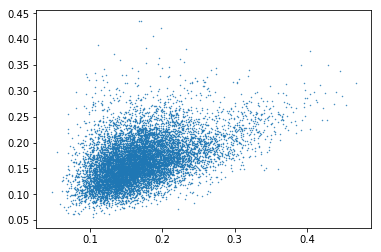

In [249]:
plt.scatter(plxpmdecor_std[condi],plxpmracor_std[condi],s=0.2)

(array([  3.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   1.00000000e+01,   1.40000000e+01,
          2.90000000e+01,   3.90000000e+01,   4.40000000e+01,
          8.70000000e+01,   1.70000000e+02,   2.29000000e+02,
          4.11000000e+02,   7.27000000e+02,   1.28100000e+03,
          2.30000000e+03,   3.84600000e+03,   6.74400000e+03,
          1.12640000e+04,   1.82620000e+04,   2.80060000e+04,
          4.11160000e+04,   5.59400000e+04,   6.77640000e+04,
          7.39550000e+04,   7.27630000e+04,   6.56090000e+04,
          5.36010000e+04,   3.81890000e+04,   1.44580000e+04]),
 array([ 12.81444263,  13.08729194,  13.36014125,  13.63299055,
         13.90583986,  14.17868916,  14.45153847,  14.72438777,
         14.99723708,  15.27008638,  15.54293569,  15.81578499,
         16.0886343 ,  16.36148361,  16.63433291,  16.90718222,
         17.18003152,  17.45288083,  17.72573013,  17.99857944,
         18.27142874,  18.54427805,  18.81712735,  19.0899

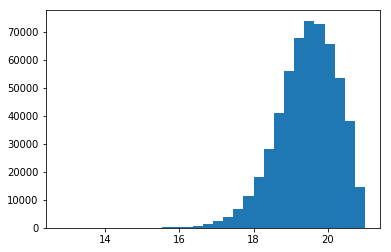

In [251]:
plt.hist(g_mag,30)

In [34]:
np.where((plxpmdecor_std<np.std(plxpmdecor)) & (plxpmdecor_std>0))[0].size*1.0/plxpmdecor_std[np.where(plxpmdecor_std>0)].size

0.9275626861369969

In [35]:
plxpmracor_std[np.where(plxpmracor_std>0)].size-plxpmdecor_std[np.where(plxpmdecor_std>0)].size

0

In [27]:
#np.median(plxpmdecor_std)
np.mean(plxpmdecor_std)
#should be  np.mean(plxpmdecor_std[np.where(plxpmdecor_std>0)])

-1.3844942814724466

$$f(s)=\sin(s+\pi)$$

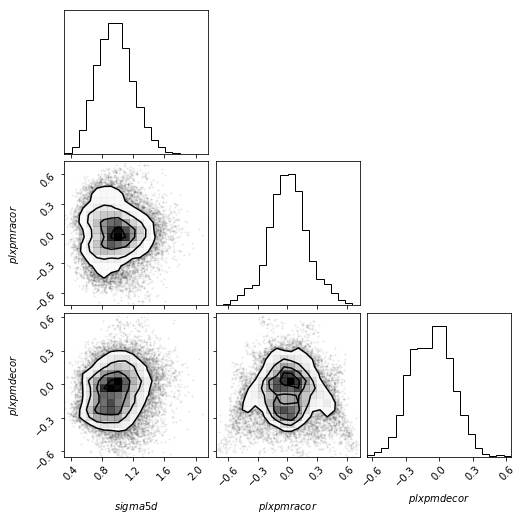

In [123]:
condi=np.where(plxpmdecor_mean>-5)
sample=np.vstack([sigma5d_max_mean[condi], plxpmracor_mean[condi], plxpmdecor_mean[condi]]).T
fig=corner.corner(sample,labels=['$sigma5d$','$plxpmracor$','$plxpmdecor$'])

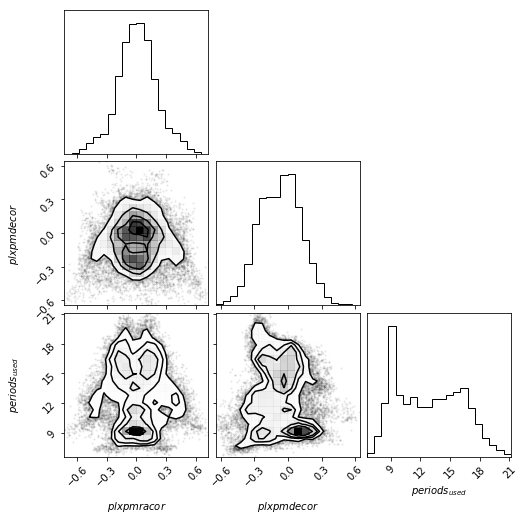

In [124]:
condi=np.where(plxpmdecor_mean>-5)
sample=np.vstack([plxpmracor_mean[condi], plxpmdecor_mean[condi], periods_used_mean[condi]]).T
fig=corner.corner(sample,labels=['$plxpmracor$','$plxpmdecor$','$periods_{used}$'])

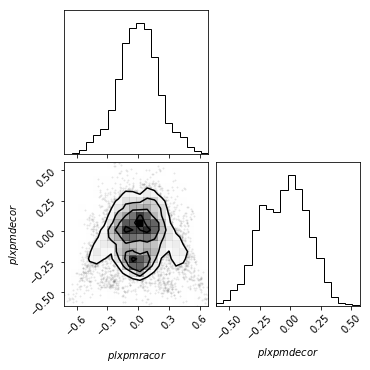

In [226]:
condi=np.where(plxpmdecor_mean>-5)
sample=np.vstack([plxpmracor_mean[condi], plxpmdecor_mean[condi]]).T
fig=corner.corner(sample,labels=['$plxpmracor$','$plxpmdecor$'])

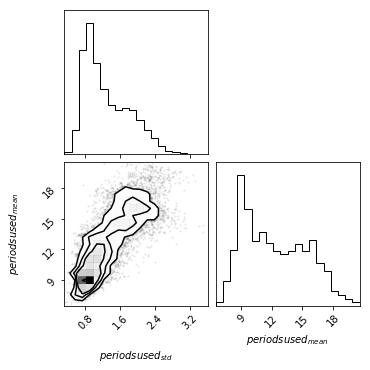

In [229]:
condi=np.where(plxpmdecor_mean>-5)
sample=np.vstack([periods_used_std[condi], periods_used_mean[condi]]).T
fig=corner.corner(sample,labels=['$periodsused_{std}$','$periodsused_{mean}$'])

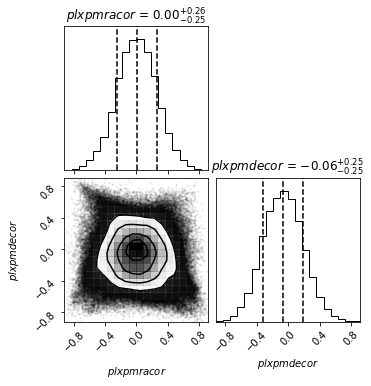

In [54]:
#sample=np.vstack([plxpmracor, plxpmdecor, sigma5d_max]).T
#fig=corner.corner(sample,labels=['$plxpmracor$','$plxpmdecor$','$sigma5d max$'])
sample=np.vstack([plxpmracor, plxpmdecor]).T
fig=corner.corner(sample,labels=['$plxpmracor$','$plxpmdecor$'],quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},  dpi=800)

fig.savefig('corner_plx_pm_cor.eps', dpi=800)

画全部的源在plxpmracor,plxpmdecor的分布

画hist2d分布图

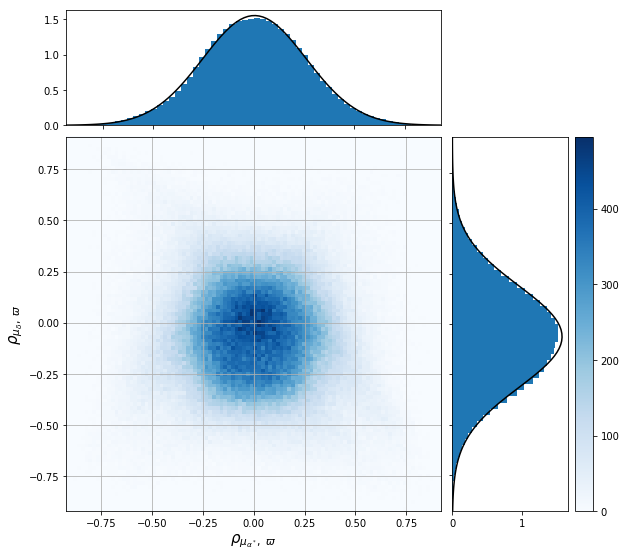

In [64]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_hist2d = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
#rect_histy = [left_h, bottom, 0.2, height]
rect_histy = [left_h, bottom, 0.25, height]


plt.figure(1, figsize=(8, 8))

axHist2d = plt.axes(rect_hist2d)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

binwidth = 0.03
xymax = np.max([np.max(np.fabs(plxpmracor)), np.max(np.fabs(plxpmdecor))])
lim = (int(xymax/binwidth) + 1) * binwidth

axHist2d.set_xlim((-lim, lim))
axHist2d.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(plxpmracor, bins=bins, normed=1)
axHisty.hist(plxpmdecor, bins=bins, orientation='horizontal', normed=1)
#axHistx.hist(plxpmracor, bins=bins, density=True, stacked=True)
#axHisty.hist(plxpmdecor, bins=bins, orientation='horizontal', density=True, stacked=True)
axHistx.set_xlim(axHist2d.get_xlim())
axHisty.set_ylim(axHist2d.get_ylim())

#fitting Rayleigh distribution
lnspc = np.linspace(-lim, lim, 100)
from scipy.stats import norm
pdf_g = norm.pdf(lnspc, loc=np.mean(plxpmracor), scale=np.std(plxpmracor)) # now get theoretical values in our interval  
axHistx.plot(lnspc, pdf_g, label="Normal", c='k') 
pdf_g = norm.pdf(lnspc, loc=np.mean(plxpmdecor), scale=np.std(plxpmdecor)) # now get theoretical values in our interval  
axHisty.plot(pdf_g, lnspc, label="Normal", c='k') 

##hex_bin=axHist2d.hexbin(plxpmracor,plxpmdecor,gridsize=(50,50))
##plt.colorbar(hex_bin)
hex_bin=axHist2d.hist2d(plxpmracor,plxpmdecor,bins=100,cmap=plt.cm.Blues)
#hex_bin=axHist2d.hist2d(plxpmracor,plxpmdecor,bins=bins,cmap=plt.cm.Blues)
'''
import matplotlib.colors as colors
hex_bin=axHist2d.hist2d(plxpmracor,plxpmdecor,bins=100, norm=colors.LogNorm())
'''
plt.colorbar(hex_bin[3])  #只有第4个分量是可以做colormap的
axHist2d.grid(True)
x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
axHist2d.set_ylabel(y_name,fontsize=15)
axHist2d.set_xlabel(x_name,fontsize=15)
plt.tight_layout()
'''##circle
circle = plt.Circle((0.0, -0.06), 0.5, color='r', fill=False)
axHist2d.add_artist(circle)
'''

#matplotlib.patches
#plt.show()
plt.savefig('plx_pm_cor.eps', dpi=400, bbox_inches = "tight")

将上图中的分布的夹角分布做图

556869
10888
599
0.727334435927
(-0.062891848, 0.00422143)


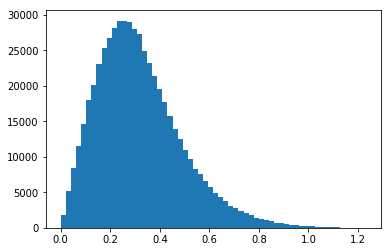

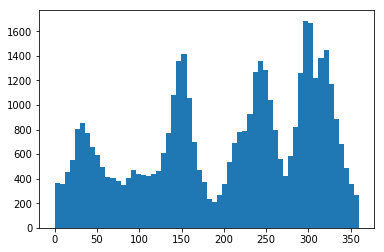

In [76]:
aim_2_ref = 0.75
aim_2=np.sqrt((0.06+plxpmdecor)**2.0+plxpmracor**2.0)
print(aim_2.size)
print(np.where(aim_2>aim_2_ref)[0].size)
print(np.where(plxpmracor>aim_2_ref)[0].size) 
print(1.0-151839.0/556869.0)
print(np.mean(plxpmdecor), np.mean(plxpmracor))
plt.hist(aim_2, 60)
plt.show()
#condi=np.where(aim_2<aim_2_ref)
condi=np.where((aim_2<aim_2_ref) & (aim_2>(aim_2_ref-0.2)))
#<aim_2_ref 分布很均匀   >aim_2_ref  分布开始不均匀
#condi=np.where(aim_2>0)
plxpmracor_=plxpmracor[condi]
plxpmdecor_=plxpmdecor[condi]

condi=np.where(plxpmracor_<-0.004)
delta1=np.rad2deg(np.arctan((plxpmracor_[condi]+0.004)/(plxpmdecor_[condi]+0.063)))+180
#plt.hist(delta1,60)
#plt.show()

condi=np.where(plxpmracor_>-0.004)
delta2=np.rad2deg(np.arctan((plxpmracor_[condi]+0.004)/(plxpmdecor_[condi]+0.063)))
#plt.hist(delta2,60)
#plt.show()

delta3=np.zeros_like(delta2)
condi3=np.where(delta2>0)
delta3[condi3]=delta2[condi3]
condi3=np.where(delta2<0)
delta3[condi3]=delta2[condi3]+360

plt.hist(np.hstack((delta1,delta3)),60)
plt.show()

(array([    27.,    142.,    259.,    329.,    539.,    779.,   1093.,
          1413.,   1876.,   2399.,   3063.,   3805.,   4579.,   5516.,
          6617.,   7621.,   8944.,  10135.,  11424.,  12869.,  14323.,
         15500.,  17099.,  17785.,  18714.,  19439.,  19829.,  20189.,
         20426.,  20625.,  20766.,  20602.,  20768.,  20565.,  20283.,
         19701.,  19161.,  18321.,  17188.,  16307.,  14775.,  13420.,
         11917.,  10487.,   9159.,   7726.,   6220.,   5174.,   4182.,
          3487.,   2709.,   2144.,   1505.,   1116.,    762.,    512.,
           269.,    152.,    102.,     31.]),
 array([-0.95304108, -0.92152682, -0.89001256, -0.8584983 , -0.82698404,
        -0.79546978, -0.76395552, -0.73244126, -0.700927  , -0.66941274,
        -0.63789848, -0.60638423, -0.57486997, -0.54335571, -0.51184145,
        -0.48032719, -0.44881293, -0.41729867, -0.38578441, -0.35427015,
        -0.32275589, -0.29124163, -0.25972737, -0.22821312, -0.19669886,
        -0.1651846 , 

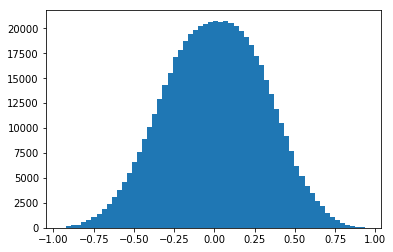

In [123]:
plt.hist(pmcor,60)

下面是绘画2维图 pcolormesh & contourf

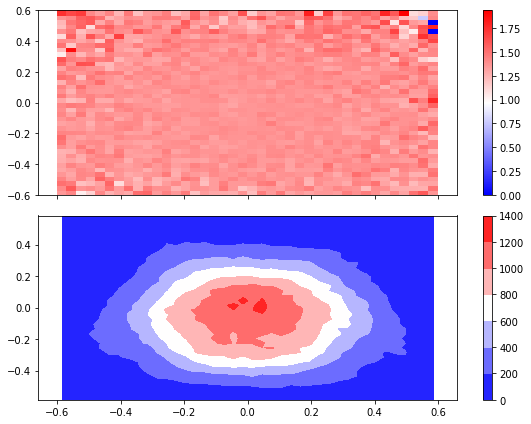

In [112]:
aim_x = plxpmracor
aim_y = plxpmdecor

cor_dx, cor_dy = 0.03, 0.03
x_min, x_max = -0.6, 0.6
y_min, y_max = -0.6, 0.6

# generate 2 2d grids for the x & y bounds
cor_y,  cor_x = np.mgrid[slice( y_min, y_max + cor_dy, cor_dy),
                slice( x_min, x_max + cor_dx, cor_dx)]

count_cor = np.zeros_like(cor_x)
plx_cor = np.zeros_like(cor_x)

for  x_m in np.arange(cor_x[0].size):
    for y_n in np.arange(cor_x.size/cor_x[0].size):
        condi_=np.where((aim_x>x_min+cor_dx*x_m) & (aim_x<x_min+cor_dx*(x_m+1)) & (aim_y>y_min+cor_dy*y_n) & (aim_y<y_min+cor_dy*(y_n+1)))
        count_cor[y_n][x_m]=condi_[0].size
        if condi_[0].size > 5:
            plx_cor[y_n][x_m] = np.mean(pm_x[condi_])
        
#fig, ax = plt.subplots(figsize=(8,6))
#fig, (ax0, ax1) = plt.subplots(nrows=2)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,6))

cmap = plt.get_cmap('bwr')
#im = ax0.pcolormesh(cor_x, cor_y, count_cor, cmap=cmap)
im = ax0.pcolormesh(cor_x, cor_y, plx_cor, cmap=cmap)
fig.colorbar(im, ax=ax0)

cf = ax1.contourf(cor_x[:-1, :-1] + cor_dx/2., cor_y[:-1, :-1] + cor_dy/2., count_cor[:-1, :-1], cmap=cmap)
#cf = ax1.contourf(cor_x[:-1, :-1] + cor_dx/2., cor_y[:-1, :-1] + cor_dy/2., plx_cor[:-1, :-1], cmap=cmap)
fig.colorbar(cf, ax=ax1)

fig.tight_layout()

plt.show()

只能用不均匀采样这个均匀分布来bootstrap所有可能的不均匀分布的平均值了

以下用pm_X作指标!

还得考虑sigma_5d在各个样本团的分布 可能是因为这个量改变导致e_pmra & e_pmde改变引起pm_X改变
(我们希望sigma_5d在一个样本的不同pmcor中分布一致)
看了一下 sigma_5d表现的比较混乱  不再考虑

In [50]:
##研究视星等对结果的影响
#condi=np.where(g_mag <= 19.5)
#condi=np.where(g_mag > 19.5)
#condi=np.where(bp_rp > 0.7)
#condi=np.where(bp_rp < 0.7)

#full sample
condi=np.where(g_mag < 21)

aim_1=periods_used[condi]
x_value=plxpmracor[condi]
x_name='plxpmracor'
y_value=plxpmdecor[condi]
y_name='plxpmdecor'
#z_value=plx
z_value=pm_x[condi] #用这个看前两项 分布平均值和平均值的偏差
zz_value=(plx[condi]-np.mean(plx[condi])) / e_plx[condi]  #用这个看结果的后两项，分别是偏差和值
#zz_value=(plx[condi]+0.029) / e_plx[condi]  #没有可见范围的差别
sigma_value=sigma5d_max[condi]

aim_2_ref = 0.25
aim_2=np.sqrt((0.06+y_value)**2.0+x_value**2.0)

def checher(condi):
    global z_value, aim_1, aim_2, aim_2_ref, sigma_value, zz_value
    print(condi[0].size)
    print('pm_x', np.mean(z_value[condi]), np.std(z_value[condi])/np.sqrt(condi[0].size), np.std(z_value[condi]))
    print('normalised_std', np.mean(zz_value[condi]), np.std(zz_value[condi])/np.sqrt(condi[0].size), np.std(zz_value[condi]))
    print('sigma5d',np.mean(sigma_value[condi]), np.std(sigma_value[condi])/np.sqrt(condi[0].size))

    print('cor module<0.25')
    condi1= np.where(aim_2 < aim_2_ref)
    condi_1=np.intersect1d(condi, condi1)
    print(condi_1.size)
    print('pm_x', np.mean(z_value[condi_1]), np.std(z_value[condi_1])/np.sqrt(condi_1.size), np.std(z_value[condi_1]))
    print('normalised_std', np.mean(zz_value[condi_1]), np.std(zz_value[condi_1])/np.sqrt(condi_1.size), np.std(zz_value[condi_1]))
    print('sigma5d',np.mean(sigma_value[condi_1]), np.std(sigma_value[condi_1])/np.sqrt(condi_1.size))
    
    print('cor module>0.25')
    condi2 = np.where(aim_2 > aim_2_ref) 
    condi_2=np.intersect1d(condi, condi2)
    print(condi_2.size)
    print('pm_x', np.mean(z_value[condi_2]), np.std(z_value[condi_2])/np.sqrt(condi_2.size), np.std(z_value[condi_2]))
    print('normalised_std', np.mean(zz_value[condi_2]), np.std(zz_value[condi_2])/np.sqrt(condi_2.size), np.std(zz_value[condi_2]))
    print('sigma5d',np.mean(sigma_value[condi_2]), np.std(sigma_value[condi_2])/np.sqrt(condi_2.size))
    
    print('\t')

print('periods_used between 13,16, relatively well distributed')
condi = np.where((aim_1<=16) & (aim_1>=13))
checher(condi)
################
print('periods_used less than 12, relatively badly distributed')
condi = np.where(aim_1<12)
checher(condi)
################
print('periods_used more than 17, relatively badly distributed')
condi = np.where(aim_1>17)
checher(condi)
################
print('FULL SAMPLE, relatively well distributed')
condi = np.where(aim_1<30)
checher(condi)


periods_used between 13,16, relatively well distributed
169745
('pm_x', 1.252490333976497, 0.0016315134490200243, 0.67218552098538364)
('normalised_std', 0.0014731389696279107, 0.0026162553915665423, 1.0779003963879619)
('sigma5d', 0.89855987, 0.0014528710892149246)
cor module<0.25
68872
('pm_x', 1.2512152333978053, 0.0025589553625651467, 0.67155882054989846)
('normalised_std', -0.0018072752796497128, 0.0040945074999727618, 1.0745410676714837)
('sigma5d', 0.91739023, 0.0022667404098990719)
cor module>0.25
100873
('pm_x', 1.2533609210221457, 0.0021177609587903308, 0.67261168260628013)
('normalised_std', 0.0037128729933631837, 0.0034010231041157048, 1.0801822855157182)
('sigma5d', 0.88570321, 0.0018915558658198471)
	
periods_used less than 12, relatively badly distributed
232318
('pm_x', 1.2511942737743889, 0.0013960493358346265, 0.67288709071243802)
('normalised_std', 0.0088264381344585908, 0.0022576914786880771, 1.0881932406152734)
('sigma5d', 1.2045429, 0.0017495318185833941)
cor modu

计算较好分布的Period_used的plx zero point [14,16]  [12,16] 都差不多

In [122]:
aim_1=periods_used
condi = np.where((aim_1<=16) & (aim_1>=14))
print(condi[0].size)
print(np.mean(plx[condi]))

125936
-0.0321163050038


In [47]:
z_value=(plx-np.mean(plx)) / e_plx
print(z_value.size)
np.std(z_value)

556869


1.0811870438209177

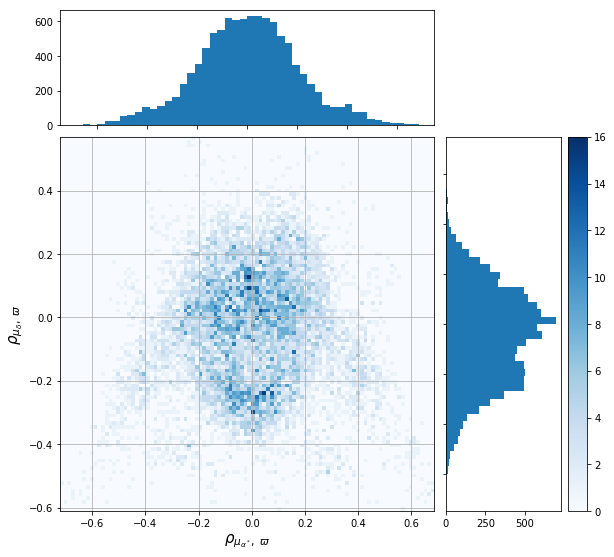

In [90]:
%config Inline.Backend.figure_format='svg'

condi=np.where(plxpmdecor_mean>-5)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_hist2d = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
#rect_histy = [left_h, bottom, 0.2, height]
rect_histy = [left_h, bottom, 0.25, height]


plt.figure(1, figsize=(8, 8))

axHist2d = plt.axes(rect_hist2d)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

binwidth = 0.03
xymax = np.max([np.max(np.fabs(plxpmracor_mean[condi])), np.max(np.fabs(plxpmdecor_mean[condi]))])
lim = (int(xymax/binwidth) + 1) * binwidth

axHist2d.set_xlim((-lim, lim))
axHist2d.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(plxpmracor_mean[condi], bins=bins)
axHisty.hist(plxpmdecor_mean[condi], bins=bins, orientation='horizontal')
#axHistx.hist(plxpmracor, bins=bins, density=True, stacked=True)
#axHisty.hist(plxpmdecor, bins=bins, orientation='horizontal', density=True, stacked=True)

axHistx.set_xlim(axHist2d.get_xlim())
axHisty.set_ylim(axHist2d.get_ylim())

#hex_bin=axHist2d.hexbin(plxpmracor,plxpmdecor,gridsize=(50,50))
#plt.colorbar(hex_bin)
hex_bin=axHist2d.hist2d(plxpmracor_mean[condi],plxpmdecor_mean[condi],bins=100,cmap=plt.cm.Blues)
plt.colorbar(hex_bin[3])  #只有第4个分量是可以做colormap的
axHist2d.grid(True)
x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
axHist2d.set_ylabel(y_name,fontsize=15)
axHist2d.set_xlabel(x_name,fontsize=15)
plt.tight_layout()


#plt.show()
plt.savefig('plx_pm_cor_spatial.eps', dpi=400, bbox_inches = "tight")

In [87]:
print(condi[0].size)
print(plxpmracor.size)

3741
556869


10409


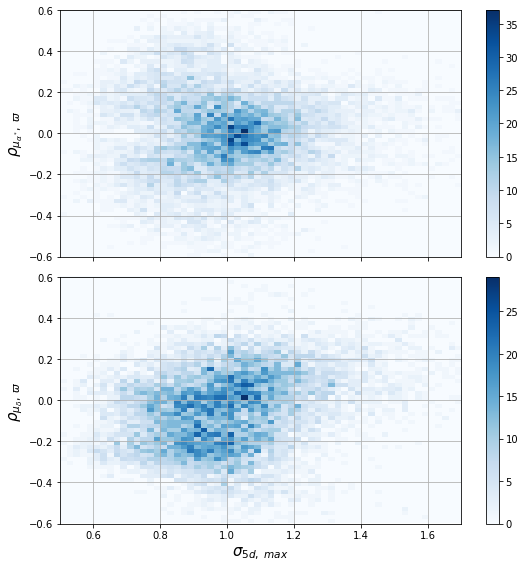

In [93]:
#fig, ax = plt.subplots(figsize=(7, 4))
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,8))

condi=np.where(plxpmdecor_mean>-5)
x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'

print(condi[0].size)
#hex_bin1=ax1.hist2d(sigma5d_max_mean[condi],plxpmracor_mean[condi],bins=60,cmin=0,cmax=18.0,cmap=plt.cm.viridis, range=np.array([0.5,1.7,-0.6,0.6]).reshape(2,2))
hex_bin1=ax1.hist2d(sigma5d_max_mean[condi],plxpmracor_mean[condi],bins=60,cmap=plt.cm.Blues, range=np.array([0.5,1.7,-0.6,0.6]).reshape(2,2))
ax1.grid(True)
ax1.set_ylabel(x_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=ax1)

hex_bin2=ax2.hist2d(sigma5d_max_mean[condi],plxpmdecor_mean[condi],bins=60,cmap=plt.cm.Blues, range=np.array([0.5,1.7,-0.6,0.6]).reshape(2,2))
#hex_bin2=ax2.hist2d(sigma5d_max_mean[condi],plxpmdecor_mean[condi],bins=60,cmap=plt.cm.viridis, range=np.array([0.5,1.7,-0.6,0.6]).reshape(2,2))
ax2.grid(True)
ax2.set_xlabel('$\sigma_{5d,\ max}$',fontsize=15)
ax2.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=ax2)

fig.tight_layout()
plt.savefig('plxpmcor_sigma5d_spatial.eps', dpi=400, bbox_inches = "tight")

In [264]:
ge=np.array([0.5,1.75,-0.6,0.6]).reshape(2,2)
print(ge)

[[ 0.5   1.75]
 [-0.6   0.6 ]]


In [106]:
np.mean(plxpmracor)

0.00422143

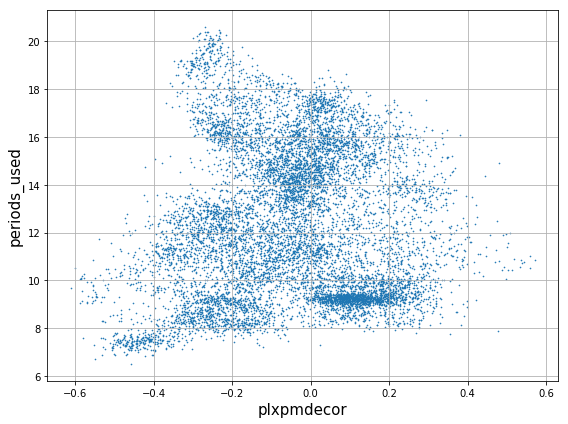

In [298]:
x_name='uwe'
x_value=uwe_mean
#_mean 是球面bin的值
y_name='plxpmracor'
y_value=plxpmracor_mean

x_name='plxpmracor'
x_value=plxpmracor_mean
y_name='plxpmdecor'
y_value=plxpmdecor_mean

x_name='plxpmracor'
x_value=plxpmracor_mean
y_name='periods_used'
y_value=periods_used_mean

x_name='plxpmdecor'
x_value=plxpmdecor_mean
y_name='periods_used'
y_value=periods_used_mean

condi=np.where(plxpmdecor_mean>-5)

fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(x_value[condi], y_value[condi],s=0.4)
ax.set_xlabel(x_name, fontsize=15)
ax.set_ylabel(y_name, fontsize=15)
ax.grid(True)
fig.tight_layout()

10409


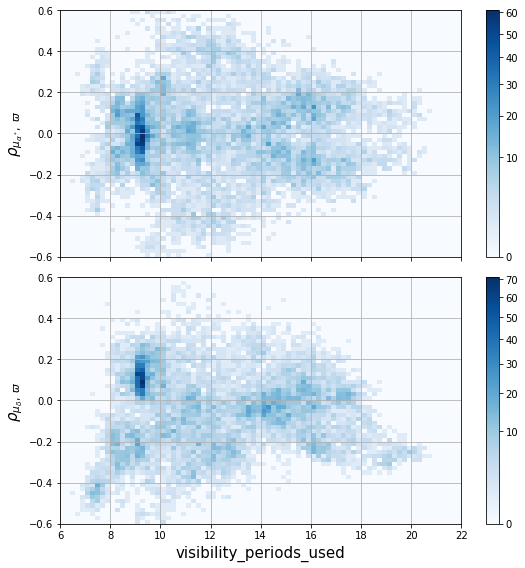

In [85]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,8))

condi=np.where(plxpmdecor_mean>-5)
print(condi[0].size)

x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
x_value=plxpmracor_mean
y_name='$\\rho_{\\mu_{\\delta},\\ \\varpi}$'
y_value=plxpmdecor_mean
z_name='visibility_periods_used'
z_value=periods_used_mean

import matplotlib.colors as mcolors

hex_bin1=ax1.hist2d(z_value[condi],x_value[condi],bins=np.array([80,60]),cmap=plt.cm.Blues, range=np.array([6,22,-0.6,0.6]).reshape(2,2),norm=mcolors.PowerNorm(0.5))
#hex_bin1=ax1.hist2d(z_value[condi],x_value[condi],bins=60,cmap=plt.cm.Blues, range=np.array([6,22,-0.6,0.6]).reshape(2,2),norm=mcolors.LogNorm())
ax1.grid(True)
ax1.set_ylabel(x_name,fontsize=15)
fig.colorbar(hex_bin1[3], ax=ax1)

hex_bin2=ax2.hist2d(z_value[condi],y_value[condi],bins=np.array([80,60]),cmap=plt.cm.Blues, range=np.array([6,22,-0.6,0.6]).reshape(2,2),norm=mcolors.PowerNorm(0.5))
ax2.grid(True)
ax2.set_xlabel(z_name,fontsize=15)
ax2.set_ylabel(y_name,fontsize=15)
fig.colorbar(hex_bin2[3],ax=ax2)

fig.tight_layout()
plt.savefig('plxpmcor_period_spatial.eps', dpi=400, bbox_inches = "tight")

In [83]:
x_name='$\\rho_{\\mu_{\\alpha^*},\\ \\varpi}$'
print(x_name)

$\rho_{\mu_{\alpha^*},\ \varpi}$
